In [332]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [333]:
pip install pystan==2.19.1.1

Note: you may need to restart the kernel to use updated packages.


In [334]:
!pip install fbprophet

In [777]:
!pip install xgboost

  Using cached xgboost-1.4.2-py3-none-macosx_10_14_x86_64.macosx_10_15_x86_64.macosx_11_0_x86_64.whl (1.2 MB)


In [778]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

from scipy.ndimage import gaussian_filter

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller,kpss
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from fbprophet import Prophet
from sklearn.metrics import make_scorer
from fbprophet.plot import add_changepoints_to_plot, plot_plotly, plot_components_plotly, plot_yearly
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import xgboost as xgb










plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Data Cleaning

In [620]:
df_train = pd.read_csv('data/train.csv')
train_data= df_train
df_test = pd.read_csv('data/test.csv')
df_store = pd.read_csv('data/store.csv')
df_sample_submission = pd.read_csv("data/sample_submission.csv")

In [621]:
df_train["Sales"].value_counts()

0        172871
5674        215
5558        197
5483        196
6049        195
          ...  
17847         1
24317         1
25114         1
19154         1
21958         1
Name: Sales, Length: 21734, dtype: int64

In [622]:
df_train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [623]:
# Merge df_store and df_train
df = df_train.merge(df_store, how='left', left_on=df_train.Store, right_on=df_store.Store)
df.drop(['key_0', 'Store_y'], axis=1, inplace=True)
df = df.rename(columns={'Store_x':'Store'})
df.shape

(1017209, 18)

In [632]:
df.head()

store  dayofweek        date  sales  customers  open  promo stateholiday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   schoolholiday storetype  ... competitionopensinceyear  promo2  \
0              1         c  ...                   2008.0       0   
1              1         a  ...                   2007.0       1   
2              1         a  ...                   2006.0       1   
3              1         c  ...                   2009.0       0   
4              1         a  ...                   2015.0       0   

   promo2sinceweek  promo2sinceyear    promointerval  timestamp  year month  \
0              NaN              NaN              NaN 2015-07-31  2015     7   
1             13.0           2010.0  Jan,Apr,Jul,Oct 2015-07-31  2015     7   
2             14.0           2011.0  Jan,Apr,Jul,Oct 2015-07-31  2015     7   
3              NaN              NaN              NaN 2015-07-31  2015     7   
4              NaN              NaN              NaN 2015-07-31  2015     7   

  day  dayofyear  
0  31        212  
1  31        212  
2  31        212  
3  31        212  
4  31        212  

[5 rows x 23 columns]

In [633]:
cols = df.columns.tolist()
cols = [col.lower() for col in cols]
df.columns = cols

In [634]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   date                       1017209 non-null  object        
 3   sales                      1017209 non-null  int64         
 4   customers                  1017209 non-null  int64         
 5   open                       1017209 non-null  int64         
 6   promo                      1017209 non-null  int64         
 7   stateholiday               1017209 non-null  object        
 8   schoolholiday              1017209 non-null  int64         
 9   storetype                  1017209 non-null  object        
 10  assortment                 1017209 non-null  object        
 11  competitiondistance        1014567 no

In [635]:
df = df.assign(
    timestamp = lambda x: pd.to_datetime(x['date']),
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear
)

In [636]:
df_test = df_test.assign(
    timestamp = lambda x: pd.to_datetime(x['Date']),
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear
)

In [637]:
train_data = train_data.assign(
    timestamp = lambda x: pd.to_datetime(x['Date']),
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear
)

In [638]:
df.head()

store  dayofweek        date  sales  customers  open  promo stateholiday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   schoolholiday storetype  ... competitionopensinceyear  promo2  \
0              1         c  ...                   2008.0       0   
1              1         a  ...                   2007.0       1   
2              1         a  ...                   2006.0       1   
3              1         c  ...                   2009.0       0   
4              1         a  ...                   2015.0       0   

   promo2sinceweek  promo2sinceyear    promointerval  timestamp  year month  \
0              NaN              NaN              NaN 2015-07-31  2015     7   
1             13.0           2010.0  Jan,Apr,Jul,Oct 2015-07-31  2015     7   
2             14.0           2011.0  Jan,Apr,Jul,Oct 2015-07-31  2015     7   
3              NaN              NaN              NaN 2015-07-31  2015     7   
4              NaN              NaN              NaN 2015-07-31  2015     7   

  day  dayofyear  
0  31        212  
1  31        212  
2  31        212  
3  31        212  
4  31        212  

[5 rows x 23 columns]

In [639]:
df['stateholiday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [640]:
df.stateholiday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: stateholiday, dtype: int64

In [641]:
df['stateholiday'].replace({0:'0'}, inplace=True)

In [642]:
df.stateholiday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: stateholiday, dtype: int64

In [643]:
round(df.describe().T,2)

count     mean      std     min     25%  \
store                      1017209.0   558.43   321.91     1.0   280.0   
dayofweek                  1017209.0     4.00     2.00     1.0     2.0   
sales                      1017209.0  5773.82  3849.93     0.0  3727.0   
customers                  1017209.0   633.15   464.41     0.0   405.0   
open                       1017209.0     0.83     0.38     0.0     1.0   
promo                      1017209.0     0.38     0.49     0.0     0.0   
schoolholiday              1017209.0     0.18     0.38     0.0     0.0   
competitiondistance        1014567.0  5430.09  7715.32    20.0   710.0   
competitionopensincemonth   693861.0     7.22     3.21     1.0     4.0   
competitionopensinceyear    693861.0  2008.69     5.99  1900.0  2006.0   
promo2                     1017209.0     0.50     0.50     0.0     0.0   
promo2sinceweek             509178.0    23.27    14.10     1.0    13.0   
promo2sinceyear             509178.0  2011.75     1.66  2009.0  2011.0   
year                       1017209.0  2013.83     0.78  2013.0  2013.0   
month                      1017209.0     5.85     3.33     1.0     3.0   
day                        1017209.0    15.70     8.79     1.0     8.0   
dayofyear                  1017209.0   162.28   101.62     1.0    77.0   

                              50%     75%      max  
store                       558.0   838.0   1115.0  
dayofweek                     4.0     6.0      7.0  
sales                      5744.0  7856.0  41551.0  
customers                   609.0   837.0   7388.0  
open                          1.0     1.0      1.0  
promo                         0.0     1.0      1.0  
schoolholiday                 0.0     0.0      1.0  
competitiondistance        2330.0  6890.0  75860.0  
competitionopensincemonth     8.0    10.0     12.0  
competitionopensinceyear   2010.0  2013.0   2015.0  
promo2                        1.0     1.0      1.0  
promo2sinceweek              22.0    37.0     50.0  
promo2sinceyear            2012.0  2013.0   2015.0  
year                       2014.0  2014.0   2015.0  
month                         6.0     8.0     12.0  
day                          16.0    23.0     31.0  
dayofyear                   153.0   241.0    365.0

In [647]:
df_train = df_train[(df_train["Open"] != 0) & (df_train['Sales'] != 0)]

### Handling NaN's

In [648]:
df.isnull().sum()

store                             0
dayofweek                         0
date                              0
sales                             0
customers                         0
open                              0
promo                             0
stateholiday                      0
schoolholiday                     0
storetype                         0
assortment                        0
competitiondistance            2642
competitionopensincemonth    323348
competitionopensinceyear     323348
promo2                            0
promo2sinceweek              508031
promo2sinceyear              508031
promointerval                508031
timestamp                         0
year                              0
month                             0
day                               0
dayofyear                         0
dtype: int64

In [649]:
df_store[pd.isnull(df_store.CompetitionDistance)]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

In [650]:
# fill NaN with a median value
df['competitiondistance'].fillna(df['competitiondistance'].median(), inplace = True)
df['competitiondistance'].isnull().sum()

0

In [651]:
tmp = df_store[pd.isnull(df_store.CompetitionOpenSinceYear  )]
tmp[tmp.CompetitionDistance != 0].shape

(354, 10)

In [652]:
tmp = df[pd.isnull(df.promo2sinceweek)]
tmp[tmp.promo2 != 0].shape

(0, 23)

In [653]:
# replace NA's by 0
df.fillna(0, inplace = True)

In [654]:
df.isnull().sum()

store                        0
dayofweek                    0
date                         0
sales                        0
customers                    0
open                         0
promo                        0
stateholiday                 0
schoolholiday                0
storetype                    0
assortment                   0
competitiondistance          0
competitionopensincemonth    0
competitionopensinceyear     0
promo2                       0
promo2sinceweek              0
promo2sinceyear              0
promointerval                0
timestamp                    0
year                         0
month                        0
day                          0
dayofyear                    0
dtype: int64

In [655]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   date                       1017209 non-null  object        
 3   sales                      1017209 non-null  int64         
 4   customers                  1017209 non-null  int64         
 5   open                       1017209 non-null  int64         
 6   promo                      1017209 non-null  int64         
 7   stateholiday               1017209 non-null  object        
 8   schoolholiday              1017209 non-null  int64         
 9   storetype                  1017209 non-null  object        
 10  assortment                 1017209 non-null  object        
 11  competitiondistance        1017209 no

In [656]:
df_test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
timestamp         0
year              0
month             0
day               0
dayofyear         0
dtype: int64

In [657]:
df_test[df_test["Open"].isnull()]

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
479      480    622          4  2015-09-17   NaN      1            0   
1335    1336    622          3  2015-09-16   NaN      1            0   
2191    2192    622          2  2015-09-15   NaN      1            0   
3047    3048    622          1  2015-09-14   NaN      1            0   
4759    4760    622          6  2015-09-12   NaN      0            0   
5615    5616    622          5  2015-09-11   NaN      0            0   
6471    6472    622          4  2015-09-10   NaN      0            0   
7327    7328    622          3  2015-09-09   NaN      0            0   
8183    8184    622          2  2015-09-08   NaN      0            0   
9039    9040    622          1  2015-09-07   NaN      0            0   
10751  10752    622          6  2015-09-05   NaN      0            0   

       SchoolHoliday  timestamp  year  month  day  dayofyear  
479                0 2015-09-17  2015      9   17        260  
1335               0 2015-09-16  2015      9   16        259  
2191               0 2015-09-15  2015      9   15        258  
3047               0 2015-09-14  2015      9   14        257  
4759               0 2015-09-12  2015      9   12        255  
5615               0 2015-09-11  2015      9   11        254  
6471               0 2015-09-10  2015      9   10        253  
7327               0 2015-09-09  2015      9    9        252  
8183               0 2015-09-08  2015      9    8        251  
9039               0 2015-09-07  2015      9    7        250  
10751              0 2015-09-05  2015      9    5        248

In [658]:
df_test.fillna(1, inplace=True)

In [659]:
df_test.isnull().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
timestamp        0
year             0
month            0
day              0
dayofyear        0
dtype: int64

### Handling Datatyp

In [660]:
df_test["Open"]= df_test["Open"].astype(int)

In [661]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             41088 non-null  int64         
 1   Store          41088 non-null  int64         
 2   DayOfWeek      41088 non-null  int64         
 3   Date           41088 non-null  object        
 4   Open           41088 non-null  int64         
 5   Promo          41088 non-null  int64         
 6   StateHoliday   41088 non-null  object        
 7   SchoolHoliday  41088 non-null  int64         
 8   timestamp      41088 non-null  datetime64[ns]
 9   year           41088 non-null  int64         
 10  month          41088 non-null  int64         
 11  day            41088 non-null  int64         
 12  dayofyear      41088 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(2)
memory usage: 4.1+ MB


In [662]:
df_test.nunique()

Id               41088
Store              856
DayOfWeek            7
Date                48
Open                 2
Promo                2
StateHoliday         2
SchoolHoliday        2
timestamp           48
year                 1
month                2
day                 31
dayofyear           48
dtype: int64

In [663]:
train_data["StateHoliday"].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

### Handling Categorical Data

In [664]:
le = LabelEncoder()

In [665]:
ass_typ = pd.get_dummies(df["assortment"], drop_first=True)
df = pd.concat([df,ass_typ], axis=1)


In [666]:
df["storetype_cat"] = le.fit_transform(df["storetype"])

In [667]:
df["stateholiday_cat"] = le.fit_transform(df["stateholiday"])

In [668]:
df_test["StateHoliday_cat"] = le.fit_transform(df_test["StateHoliday"])

In [669]:
train_data['StateHoliday'].replace({0:'0'}, inplace=True)

In [670]:
train_data["StateHoliday_cat"] = le.fit_transform(train_data["StateHoliday"])

In [671]:
df =df.rename(columns={"b" : "ass_extra"})

In [672]:
df =df.rename(columns={"c" : "ass_extended"})

In [673]:
df["stateholiday_cat"].unique()

array([0, 1, 2, 3])

In [376]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   date                       1017209 non-null  object        
 3   sales                      1017209 non-null  int64         
 4   customers                  1017209 non-null  int64         
 5   open                       1017209 non-null  int64         
 6   promo                      1017209 non-null  int64         
 7   stateholiday               1017209 non-null  object        
 8   schoolholiday              1017209 non-null  int64         
 9   storetype                  1017209 non-null  object        
 10  assortment                 1017209 non-null  object        
 11  competitiondistance        1017209 no

In [674]:
df.stateholiday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: stateholiday, dtype: int64

In [675]:
df.stateholiday_cat.value_counts()

0    986159
1     20260
2      6690
3      4100
Name: stateholiday_cat, dtype: int64

In [676]:
df["timestamp"].nunique()

942

In [677]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                41088 non-null  int64         
 1   Store             41088 non-null  int64         
 2   DayOfWeek         41088 non-null  int64         
 3   Date              41088 non-null  object        
 4   Open              41088 non-null  int64         
 5   Promo             41088 non-null  int64         
 6   StateHoliday      41088 non-null  object        
 7   SchoolHoliday     41088 non-null  int64         
 8   timestamp         41088 non-null  datetime64[ns]
 9   year              41088 non-null  int64         
 10  month             41088 non-null  int64         
 11  day               41088 non-null  int64         
 12  dayofyear         41088 non-null  int64         
 13  StateHoliday_cat  41088 non-null  int64         
dtypes: datetime64[ns](1), 

# Eda

## Question: Are the Promos effective?

In [379]:
df.groupby('storetype')['sales'].describe()

count          mean          std  min     25%     50%       75%  \
storetype                                                                       
a          551627.0   5738.179710  3964.028134  0.0  3508.0  5618.0   7860.00   
b           15830.0  10058.837334  5280.525506  0.0  6227.0  9025.5  13082.75   
c          136840.0   5723.629246  3721.700886  0.0  3789.0  5766.0   7849.00   
d          312912.0   5641.819243  3473.393781  0.0  3986.0  5826.0   7691.00   

               max  
storetype           
a          41551.0  
b          38722.0  
c          31448.0  
d          38037.0

In [380]:
df.groupby('storetype')['customers', 'sales'].sum()

customers       sales
storetype                       
a          363541434  3165334859
b           31465621   159231395
c           92129705   783221426
d          156904995  1765392943

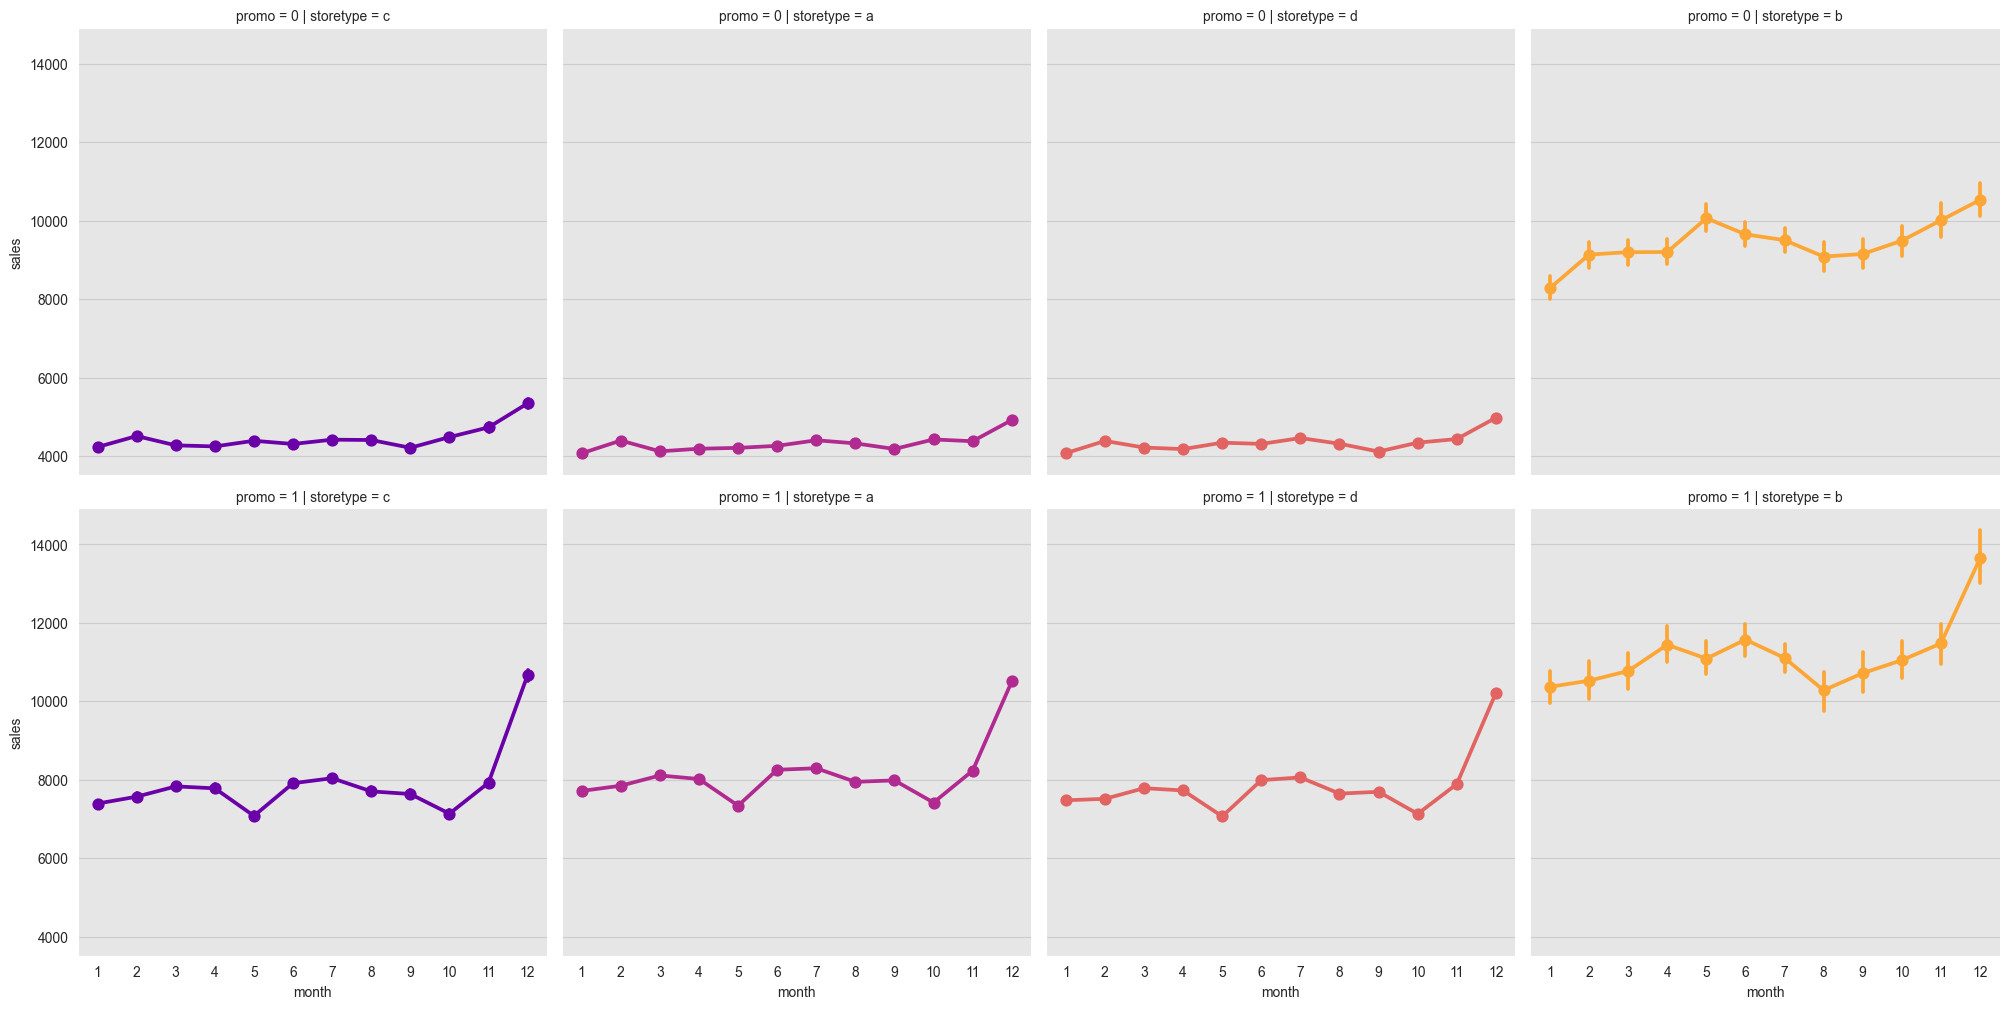

In [381]:
# sales trends
sns.factorplot(data = df, x = 'month', y = "sales", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', 
               ) 

## Finding

Storetype B has the highest sales numbers, with the largest variance. All storetypes show increased sales numbers towards christmas. 

Stores which have run a promo, show higher sales. But storetypes a,c and d show a dip towards easter, if they have run a promo, which is not the case for stores without a promo.

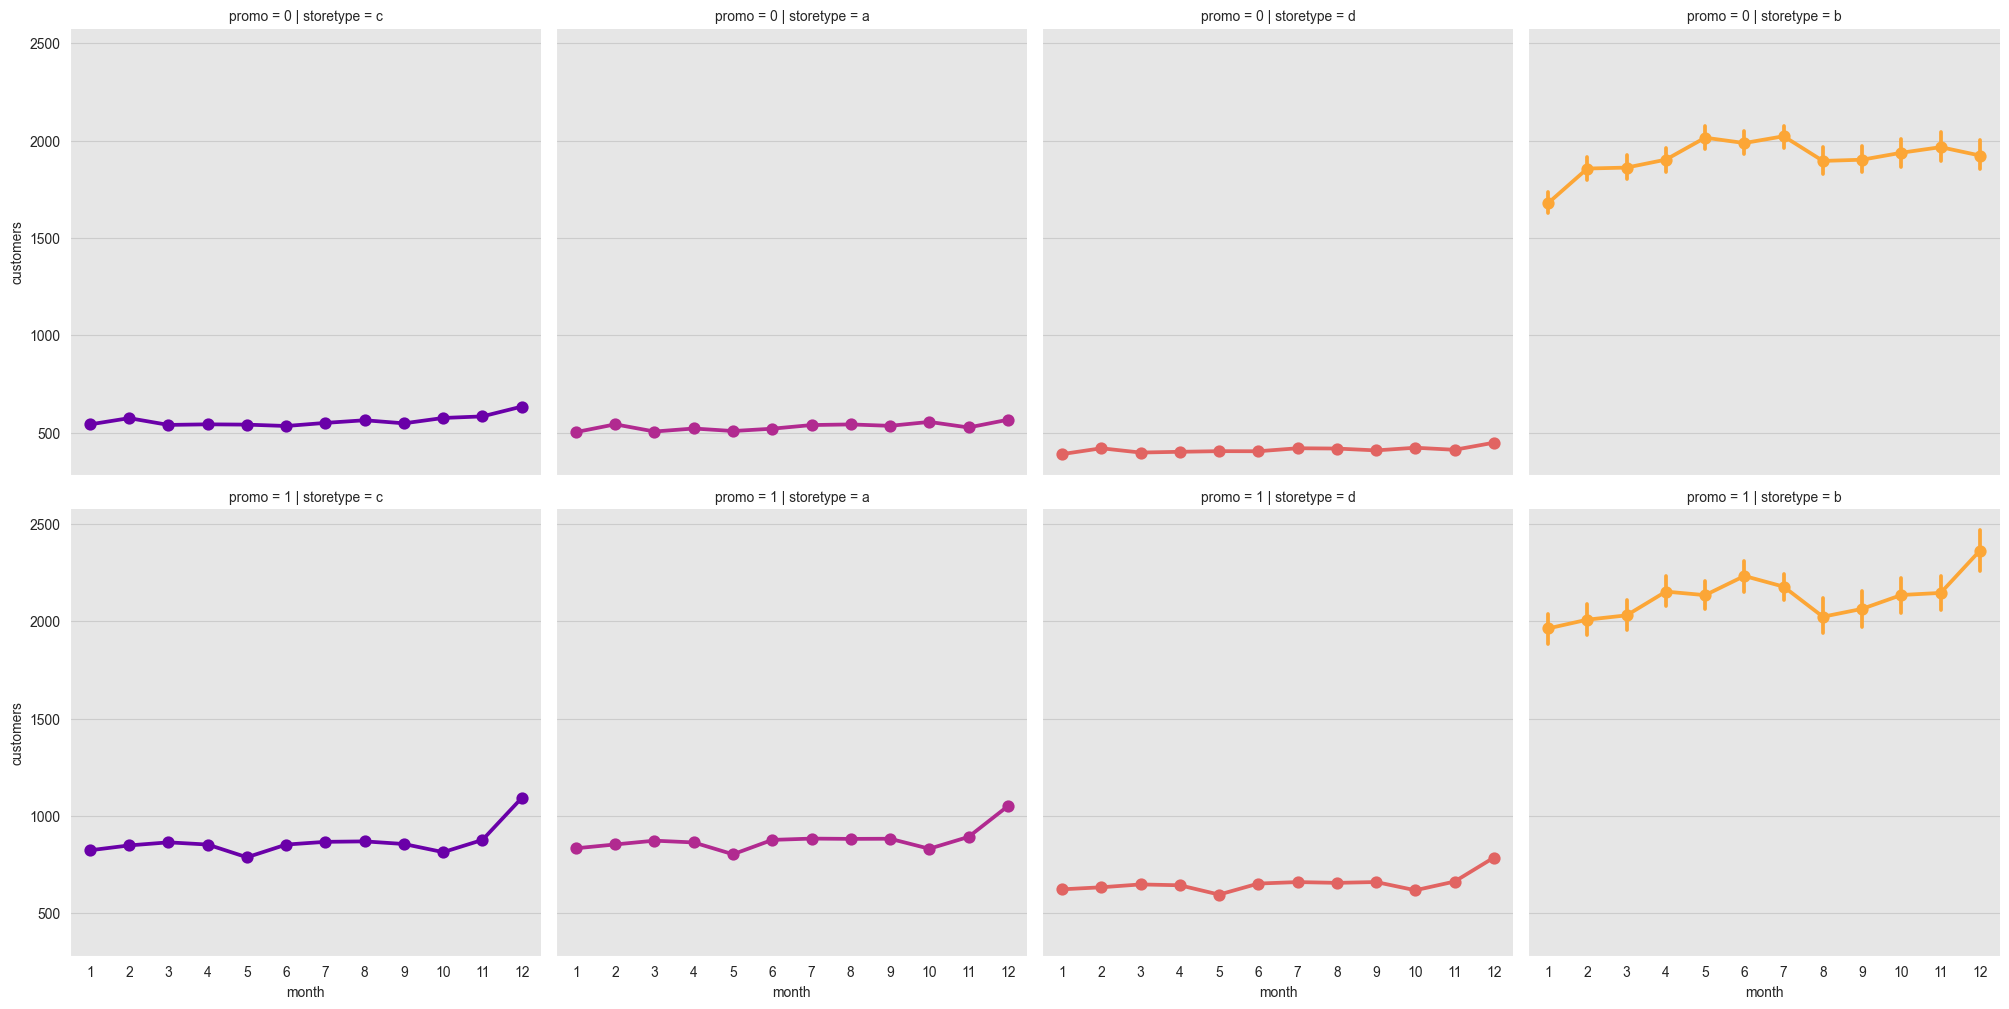

In [382]:
# customers trends
sns.factorplot(data = df, x = 'month', y = "customers", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

## Finding

Storetype B has the highest number of customers, with the largest variance. All storetypes show an increase of customers towards christmas. This trend is higher, if they have run a promo.

Same effect of a dip for storetypes a,c and d in customers towards easter can be also be seen here.

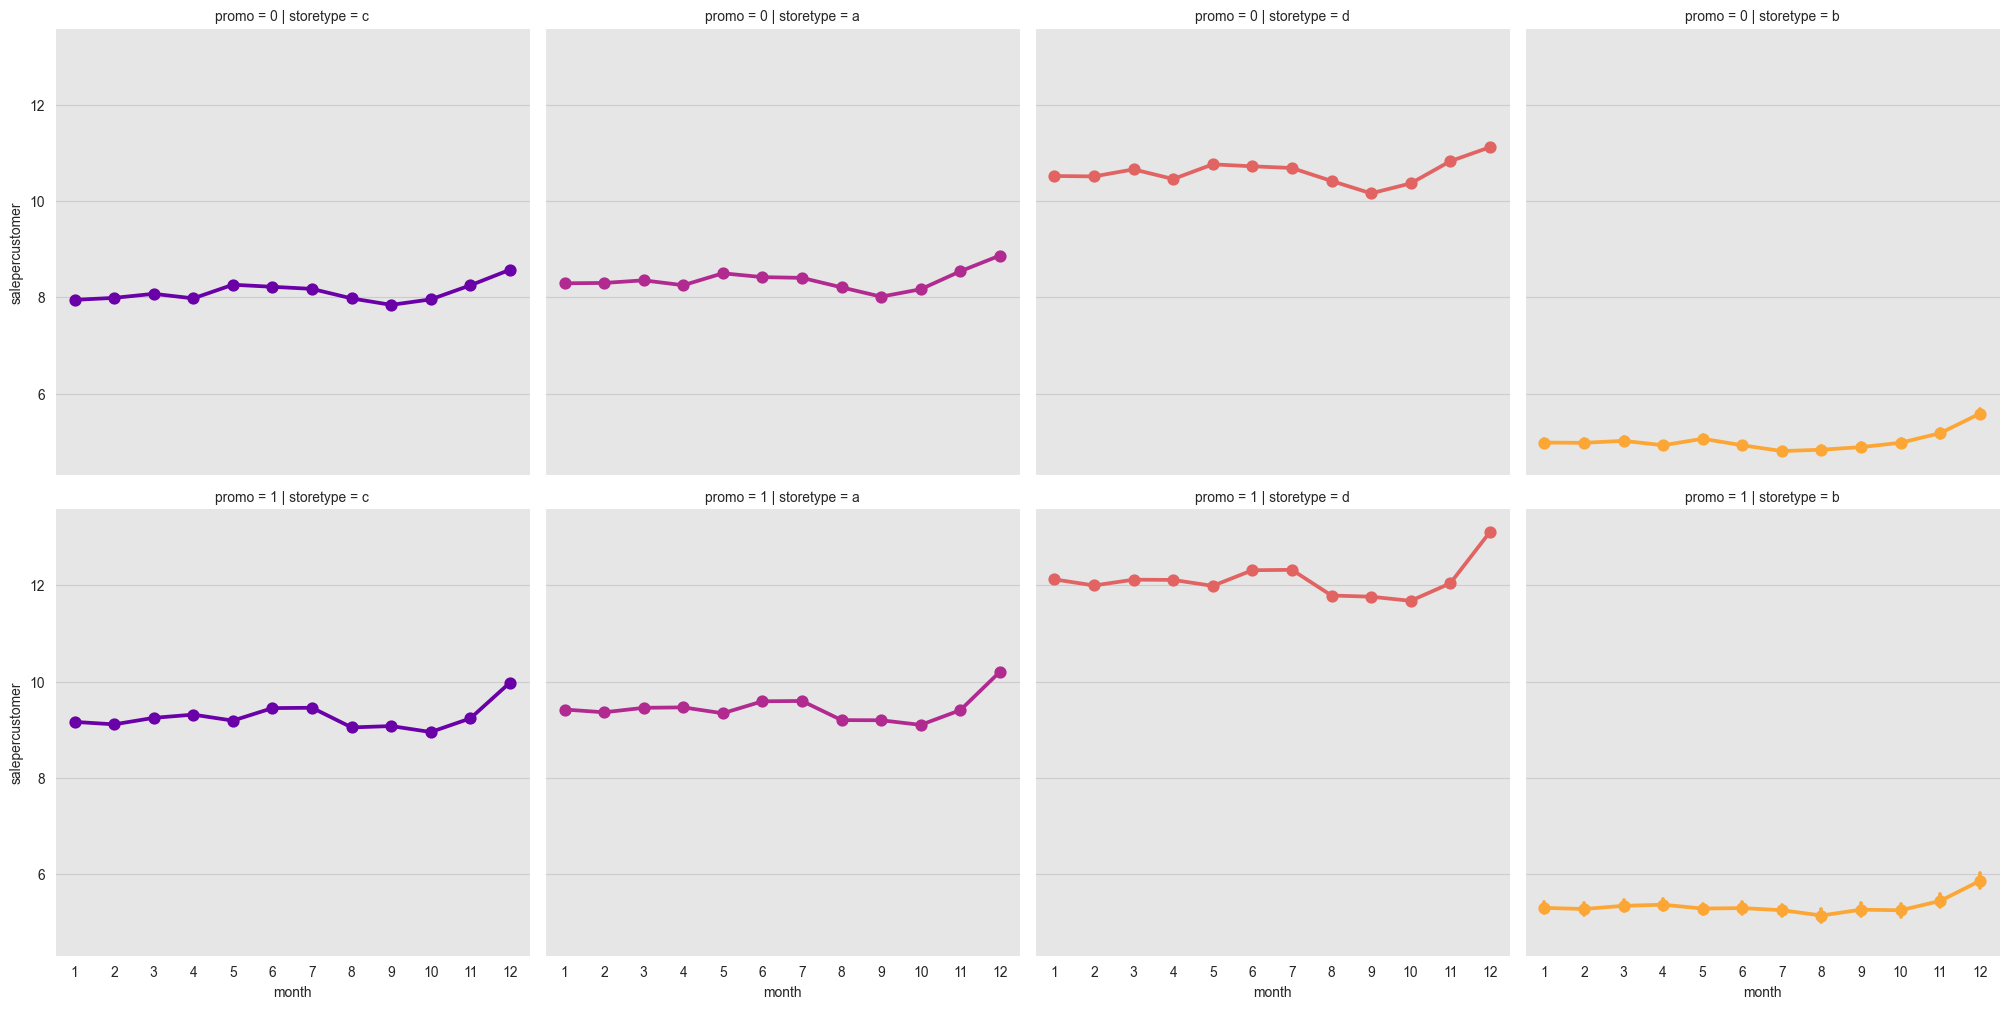

In [678]:
# sale per customer trends
df['salepercustomer'] = df['sales']/df['customers']
sns.factorplot(data = df, x = 'month', y = "salepercustomer", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', 
               ) 

## Finding

Sales per customer:
storetype b seems to be where customers only buy small items in low numbers (possible trainstation location?)
storetype d customers buy the largest quantity
a und c are very similar

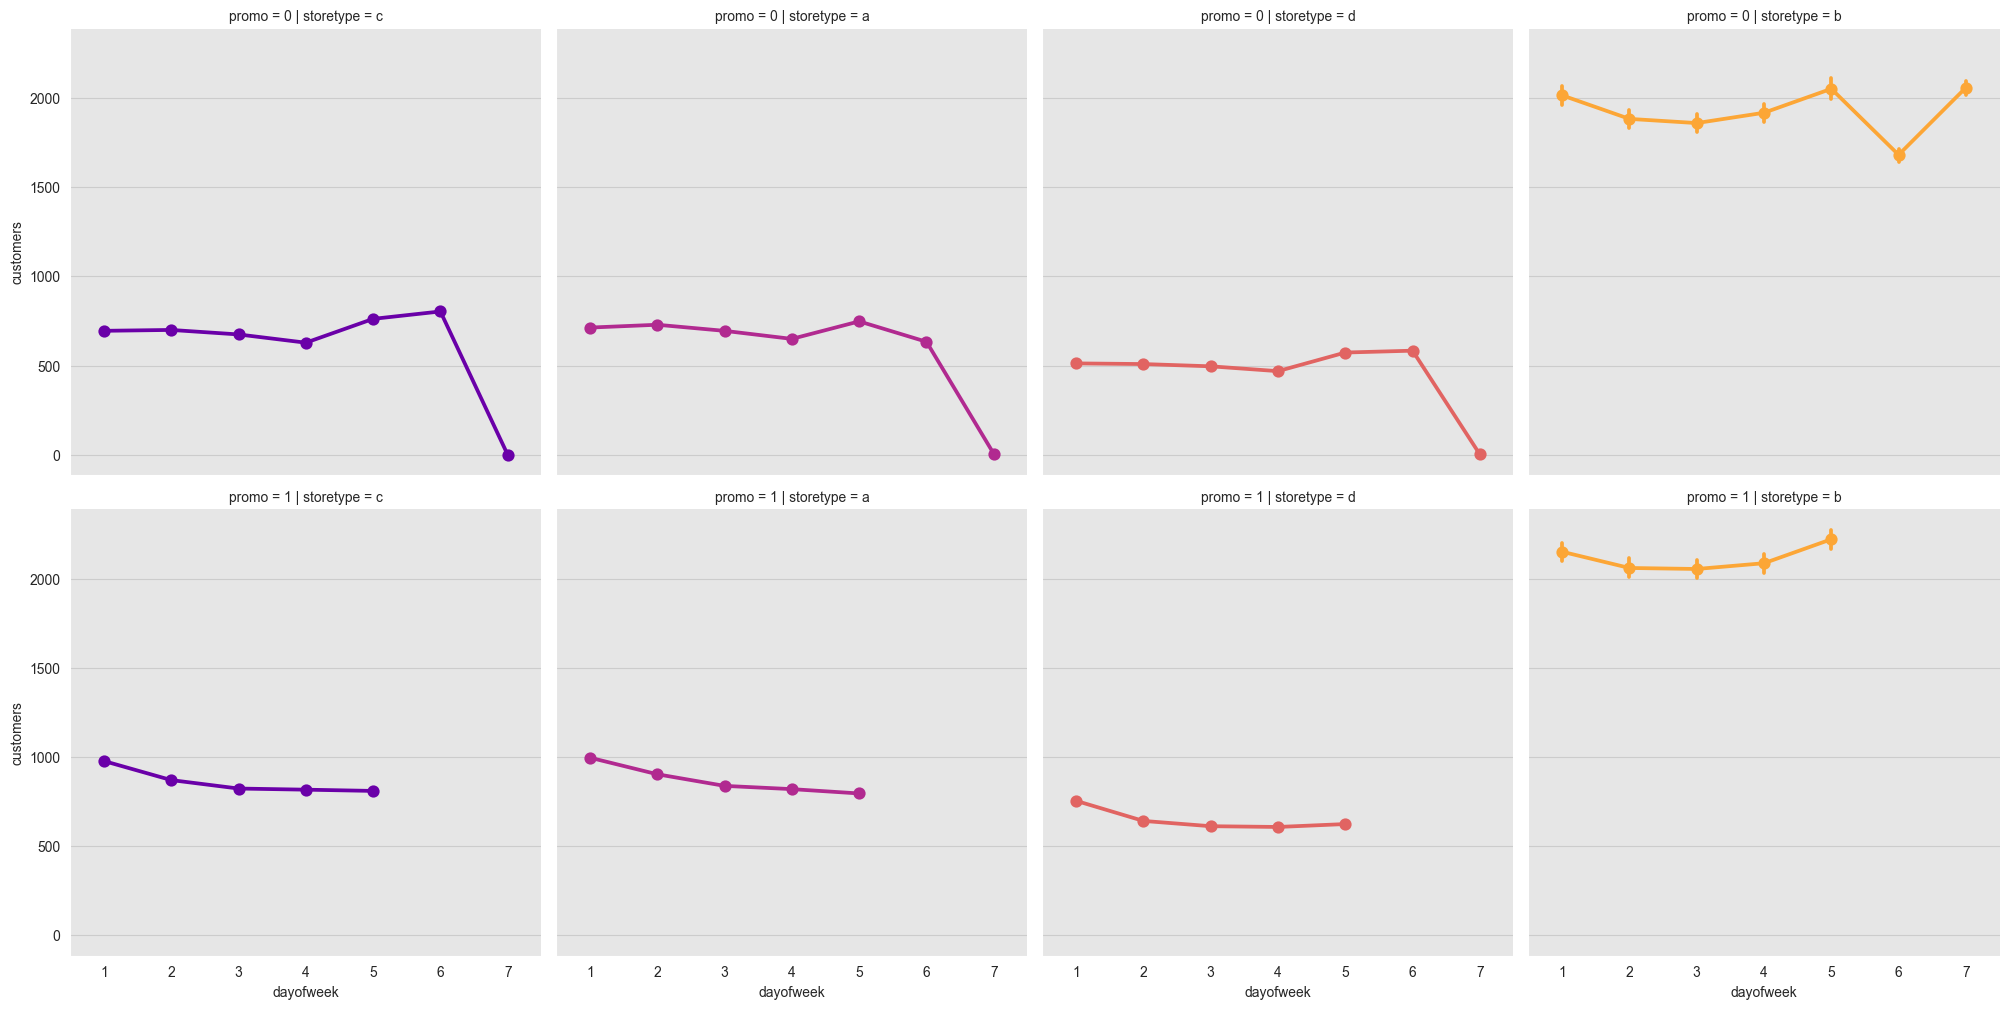

In [384]:
# weekday trends
sns.factorplot(data = df, x = 'dayofweek', y = "customers", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

## Finding

Promos are run only during the work-week, no promo on saturday/sunday.

Storetype b also open on sundays -> trainstation, fo sho
storetyp a lower number of customers on saturday, c and d increased

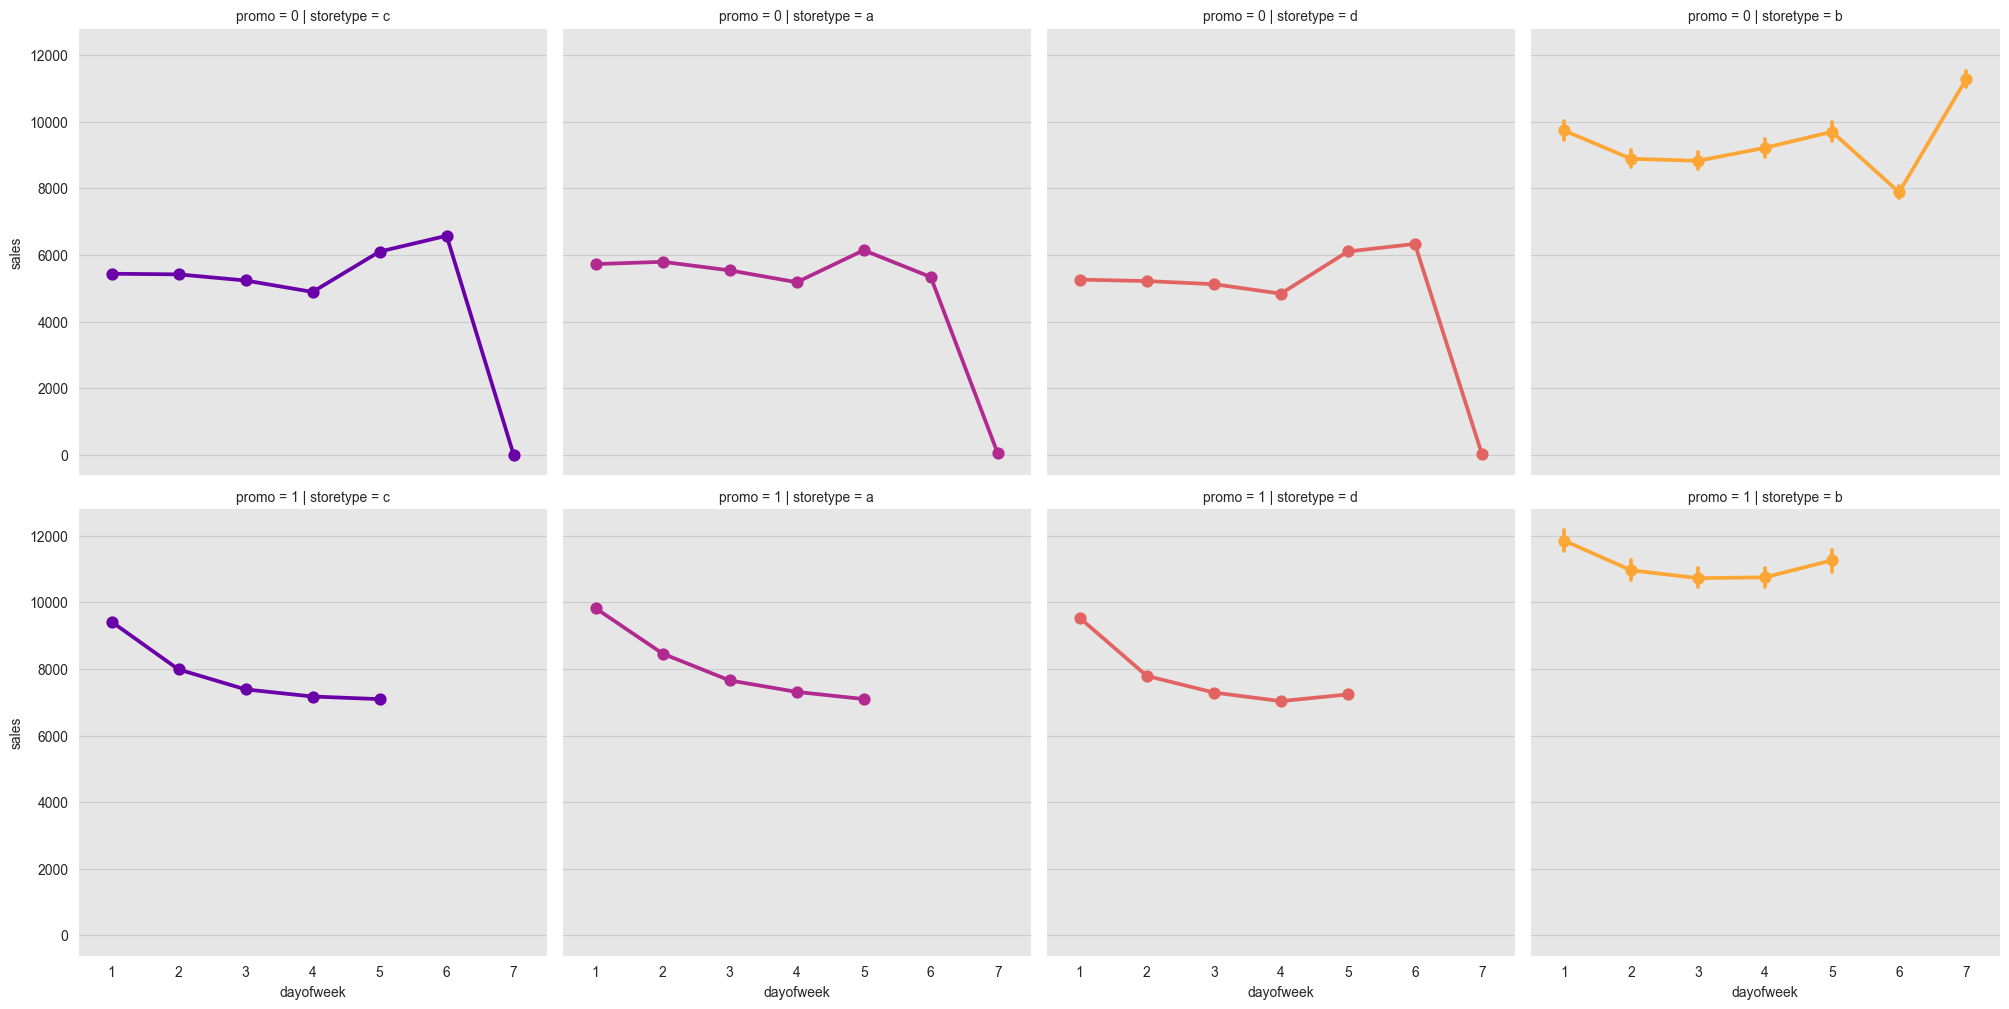

In [385]:
# weekday trends
sns.factorplot(data = df, x = 'dayofweek', y = "sales", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

Similar trends regarding sales numbers and customers.
Highest number of sales and customers on mondays, if a promo was run

## Conclusion : Question: Are the Promos effective?
- Promos are run only during the work-week, no promo on saturday/sunday
- Storetype B has the highest number of customers, with the largest variance
- Storetype B has the highest sales numbers, with the largest variance
- All storetypes show increased sales numbers towards christmas
- Stores which have run a promo, show higher sales. But storetypes a, c and d show a dip towards easter, if they have run a promo, which is not the case for       stores without a promo

In [386]:
## beachte: date, (assortment, storetype und stateholiday,assortment) müssen noch raus. die in der klammer sind schon durch kategorische Variablen ersetzt

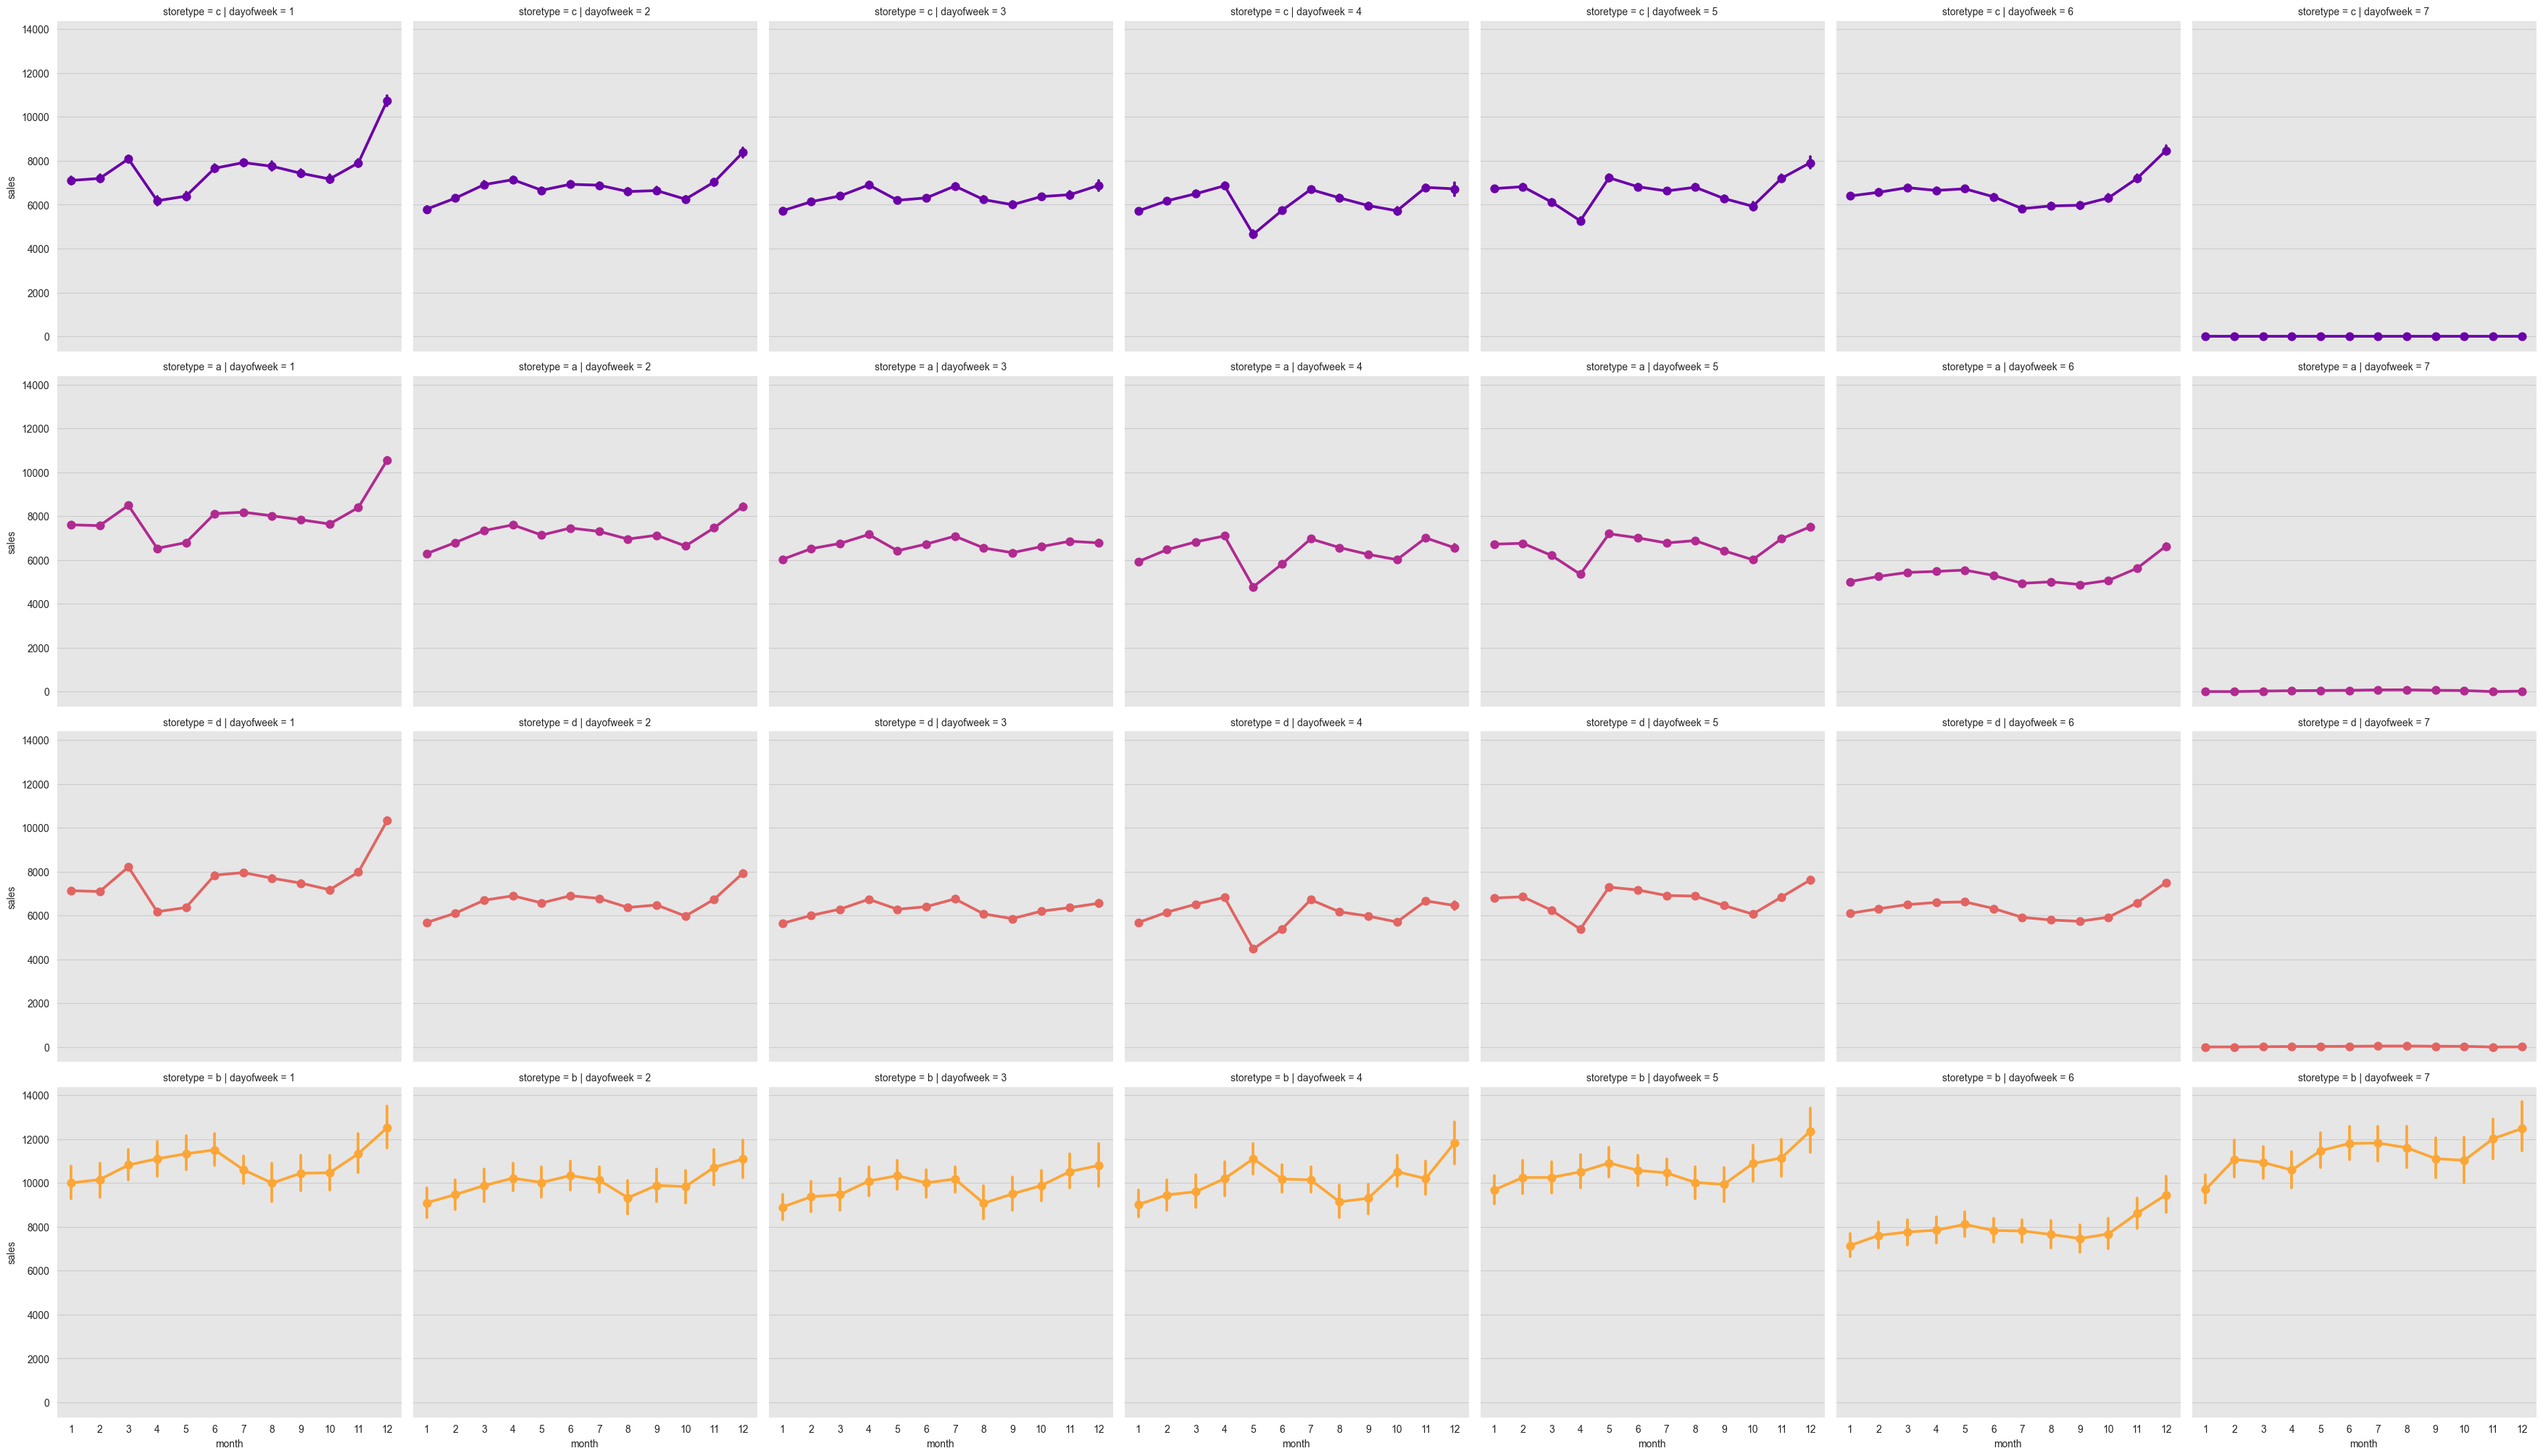

In [387]:
sns.factorplot(data = df, x = 'month', y = "sales", 
               col = 'dayofweek', 
               palette = 'plasma',
               hue = 'storetype',
               row = 'storetype',
               ) 

This shows the sales per storetyp across all months for each weekday.

In [388]:
# stores which are opened on Sundays
df[(df.open == 1) & (df.dayofweek == 7)]['store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  931,  948, 1045, 1081, 1097, 1099,  877])

These are the stores, which are open on sundays.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


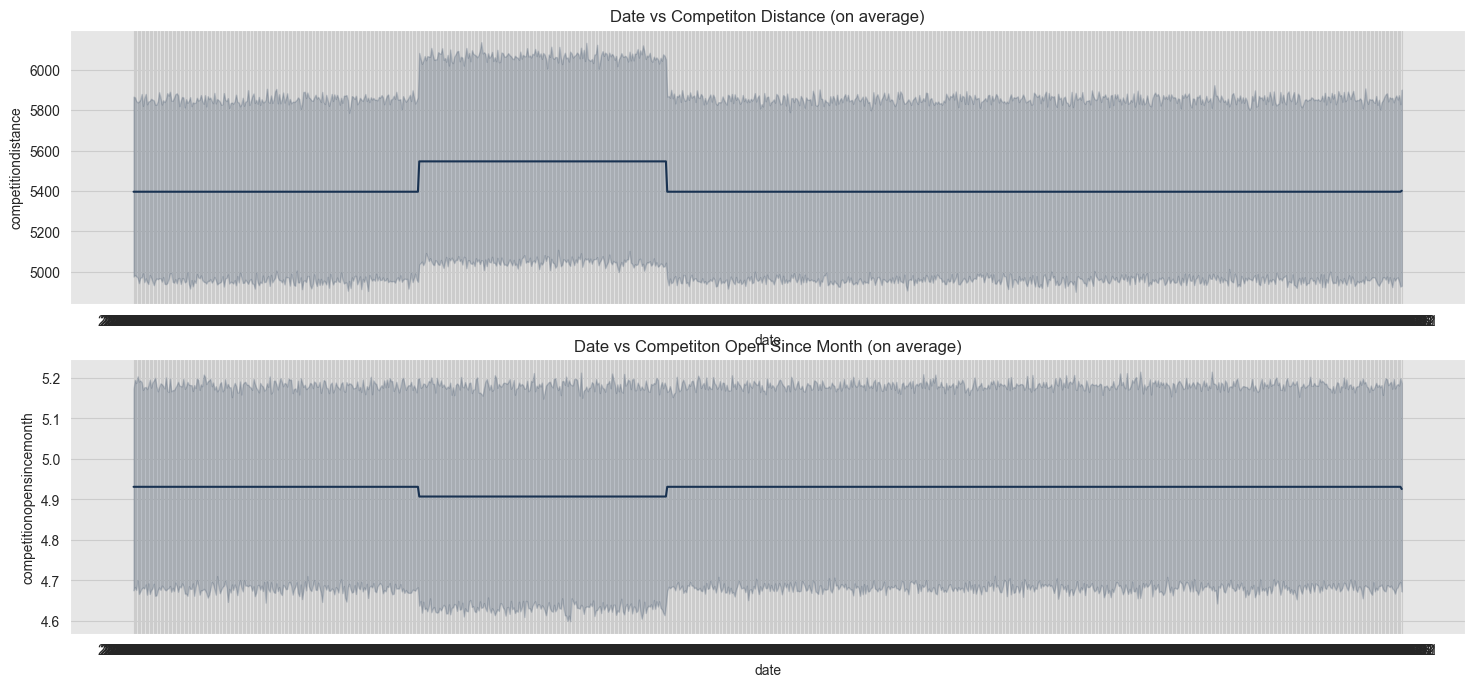

In [389]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
sns.lineplot(x = "date", y = df.groupby(df.index).mean()["competitiondistance"] , data=df, ax=axes[0])
sns.lineplot(x = "date", y = df.groupby(df.index).mean()["competitionopensincemonth"]  , data=df, ax=axes[1])

axes[0].set_title("Date vs Competiton Distance (on average)")
axes[1].set_title("Date vs Competiton Open Since Month (on average)")
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


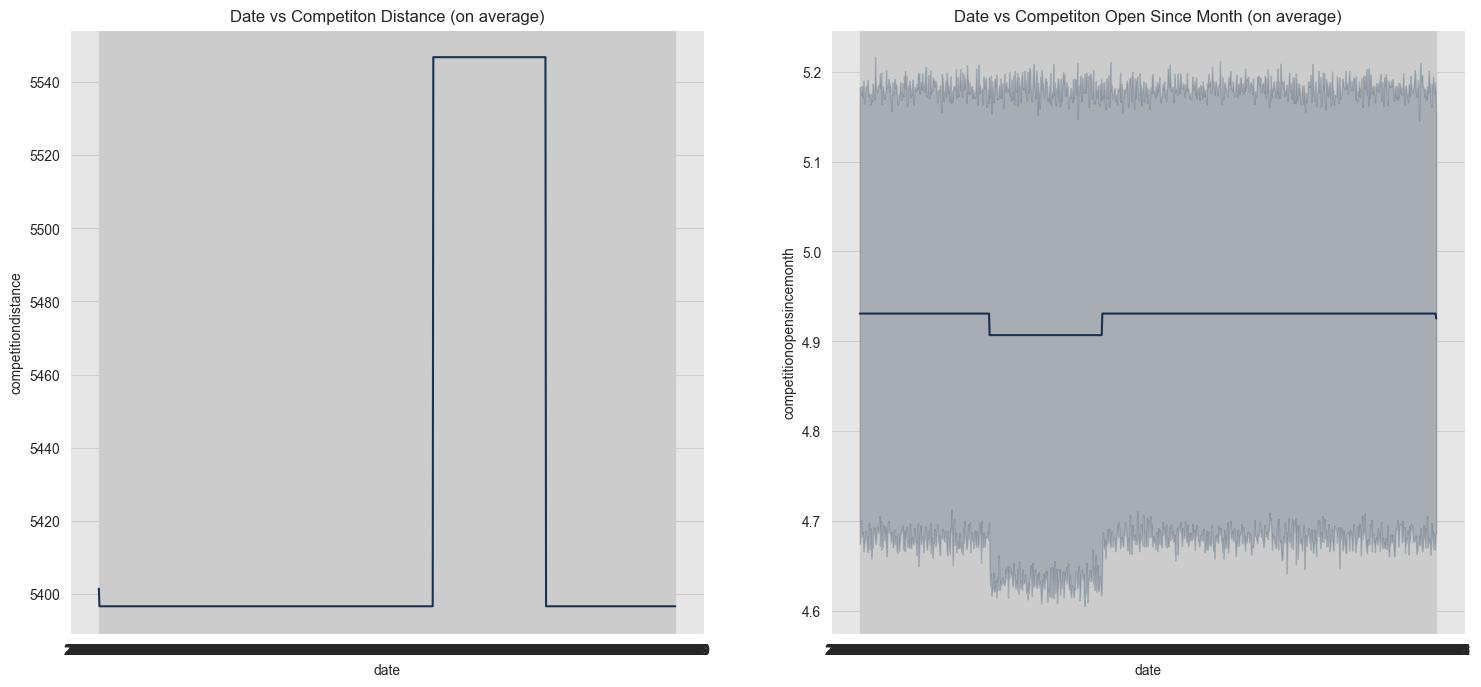

In [390]:
temp_df = df.copy()
temp_df.index = temp_df.date
temp_df = temp_df.groupby(temp_df.index).mean()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
sns.lineplot(x = "date", y = "competitiondistance" , data=temp_df, ax=axes[0])
sns.lineplot(x = "date", y = "competitionopensincemonth"  , data=df, ax=axes[1])

axes[0].set_title("Date vs Competiton Distance (on average)")
axes[1].set_title("Date vs Competiton Open Since Month (on average)")
plt.show()



In [391]:
df_store.describe().T

count         mean          std     min     25%  \
Store                      1115.0   558.000000   322.017080     1.0   279.5   
CompetitionDistance        1112.0  5404.901079  7663.174720    20.0   717.5   
CompetitionOpenSinceMonth   761.0     7.224704     3.212348     1.0     4.0   
CompetitionOpenSinceYear    761.0  2008.668857     6.195983  1900.0  2006.0   
Promo2                     1115.0     0.512108     0.500078     0.0     0.0   
Promo2SinceWeek             571.0    23.595447    14.141984     1.0    13.0   
Promo2SinceYear             571.0  2011.763573     1.674935  2009.0  2011.0   

                              50%     75%      max  
Store                       558.0   836.5   1115.0  
CompetitionDistance        2325.0  6882.5  75860.0  
CompetitionOpenSinceMonth     8.0    10.0     12.0  
CompetitionOpenSinceYear   2010.0  2013.0   2015.0  
Promo2                        1.0     1.0      1.0  
Promo2SinceWeek              22.0    37.0     50.0  
Promo2SinceYear            2012.0  2013.0   2015.0

<AxesSubplot:xlabel='Store', ylabel='CompetitionOpenSinceMonth'>

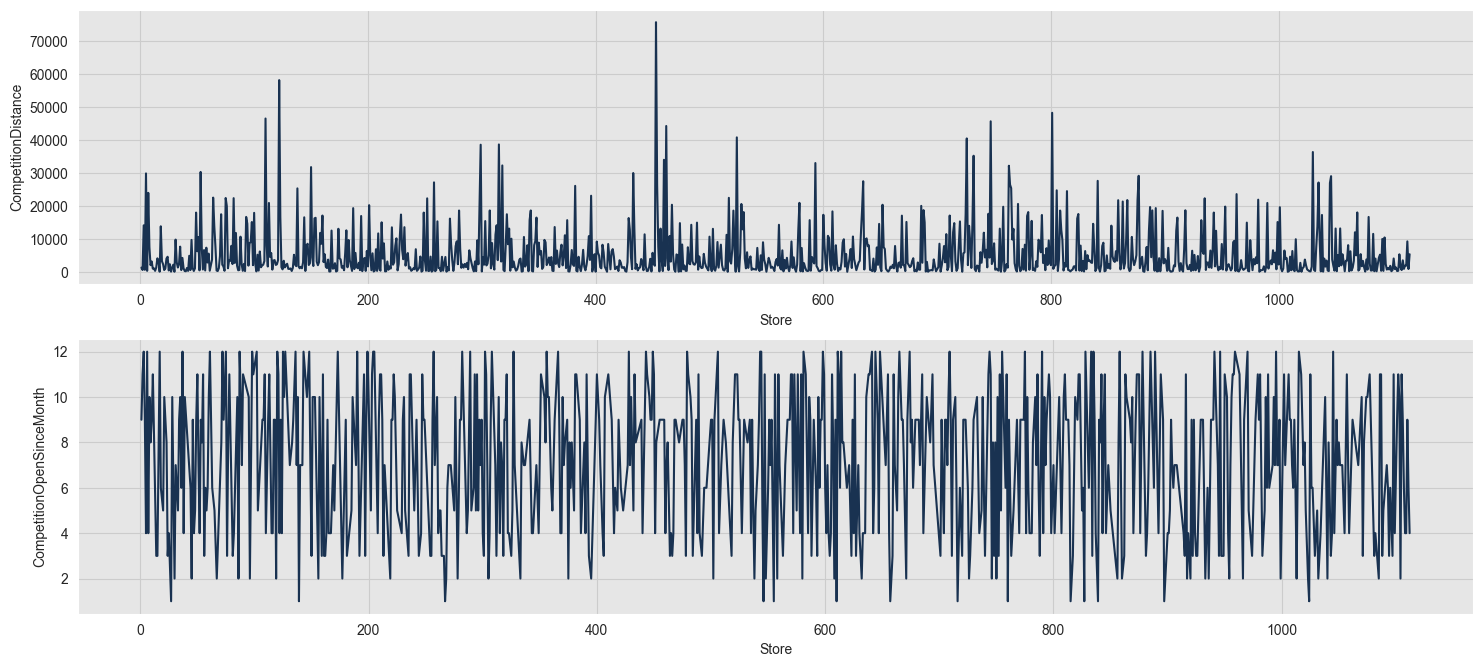

In [392]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
sns.lineplot(x = "Store", y = "CompetitionDistance" , data=df_store, ax=axes[0])
sns.lineplot(x = "Store", y = "CompetitionOpenSinceMonth"  , data=df_store, ax=axes[1])

<AxesSubplot:xlabel='CompetitionDistance', ylabel='Count'>

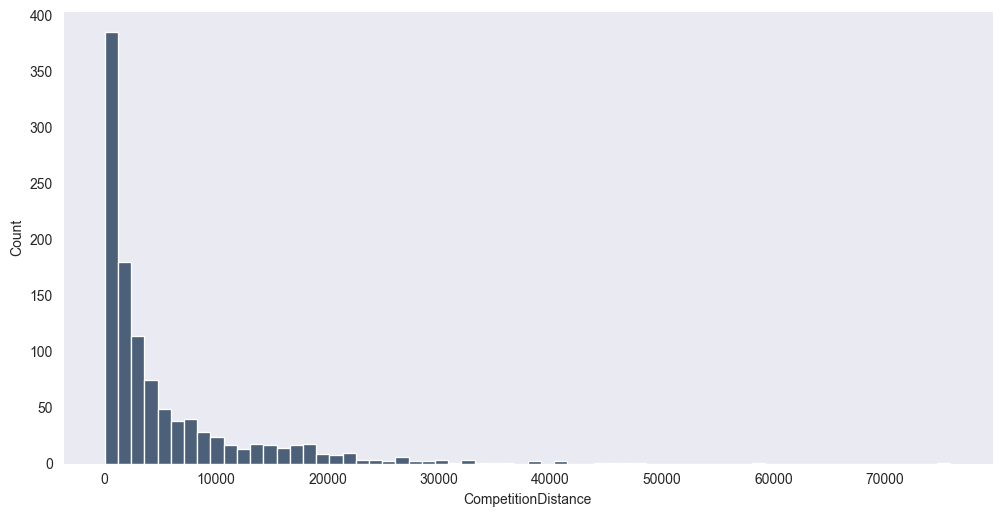

In [393]:
sns.set_style("dark")
sns.histplot(data=df_store, x="CompetitionDistance")


Text(0.5, 1.0, 'Number of Different Assortments per Store Type')

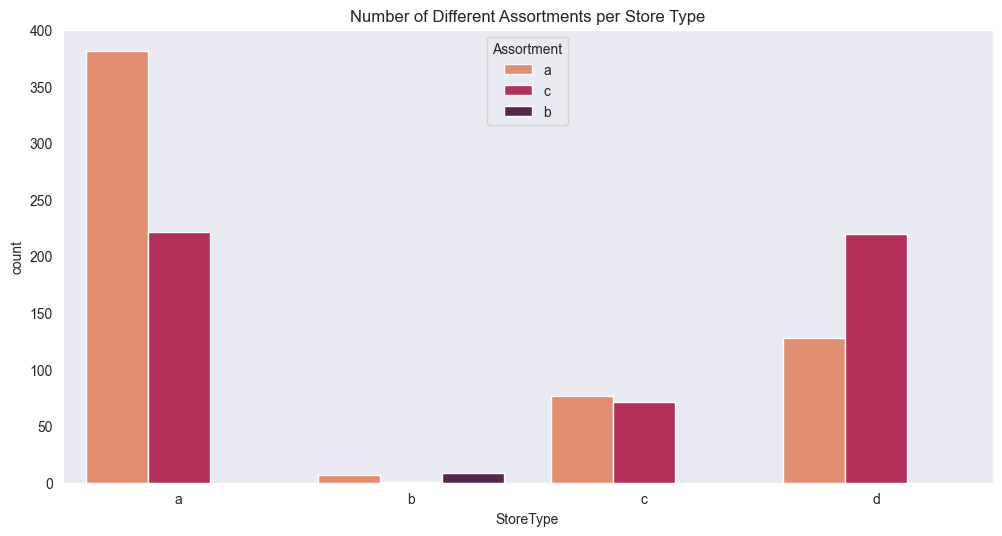

In [394]:
sns.countplot(x="StoreType",hue="Assortment",order=["a","b","c","d"], 
                                     data=df_store,palette="rocket_r").set_title("Number of Different Assortments per Store Type")

## Aggregated Plots

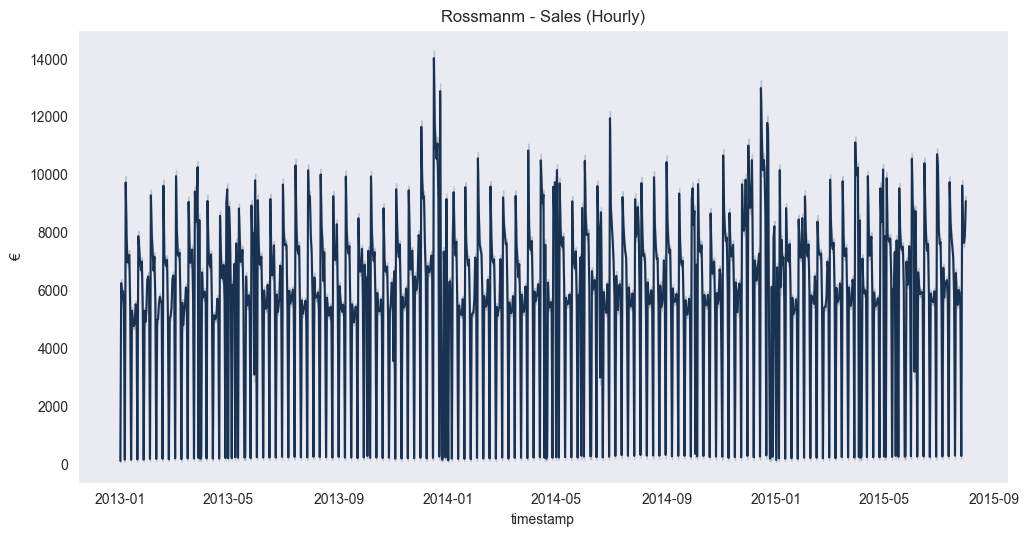

In [395]:
fig, ax = plt.subplots()
sns.lineplot(x='timestamp', y='sales', data=df, ax=ax)
ax.set(title='Rossmanm - Sales (Hourly)', ylabel="€");

In [396]:
# Aggregate Sales by day
daily_data_df = df \
    .groupby([ "date",'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'sales': np.mean}) \
    .set_index('date')

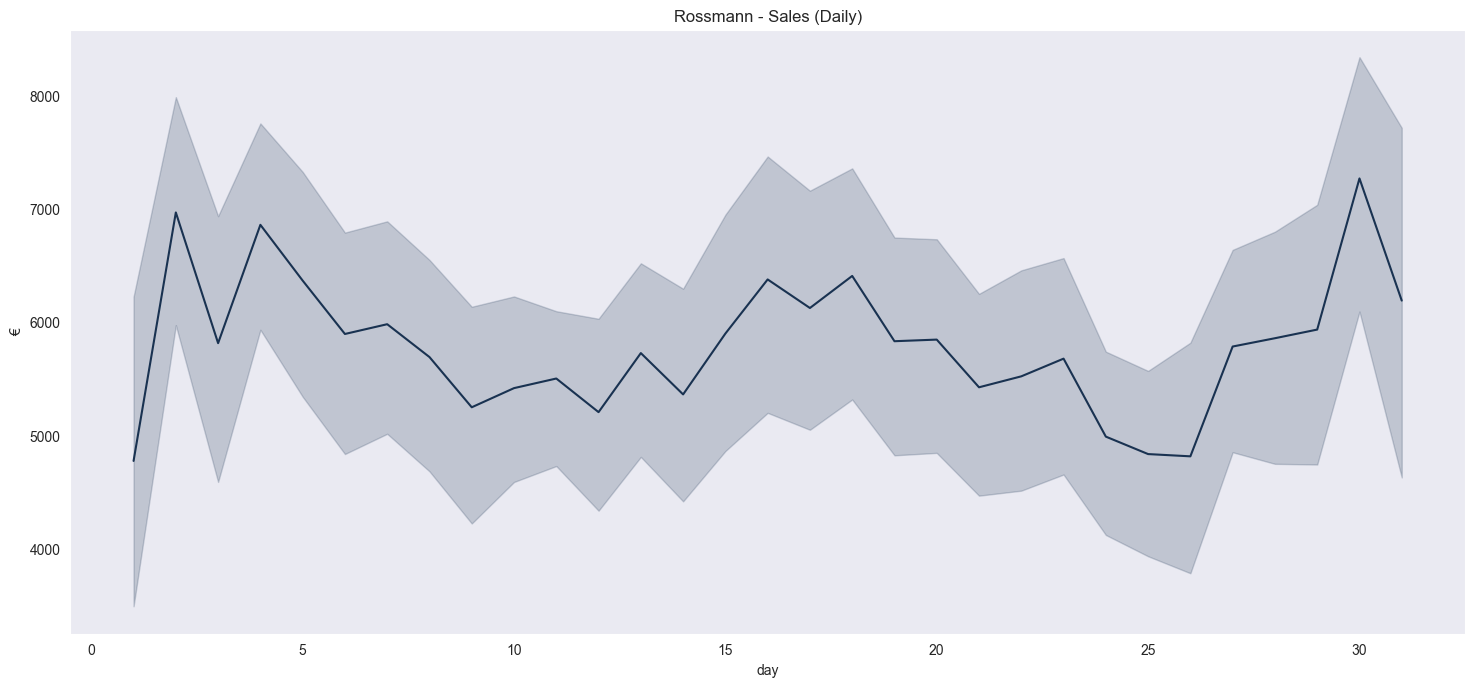

In [397]:
# Plot Sales on daily basis 
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x='day', y='sales', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Rossmann - Sales (Daily)', ylabel="€");

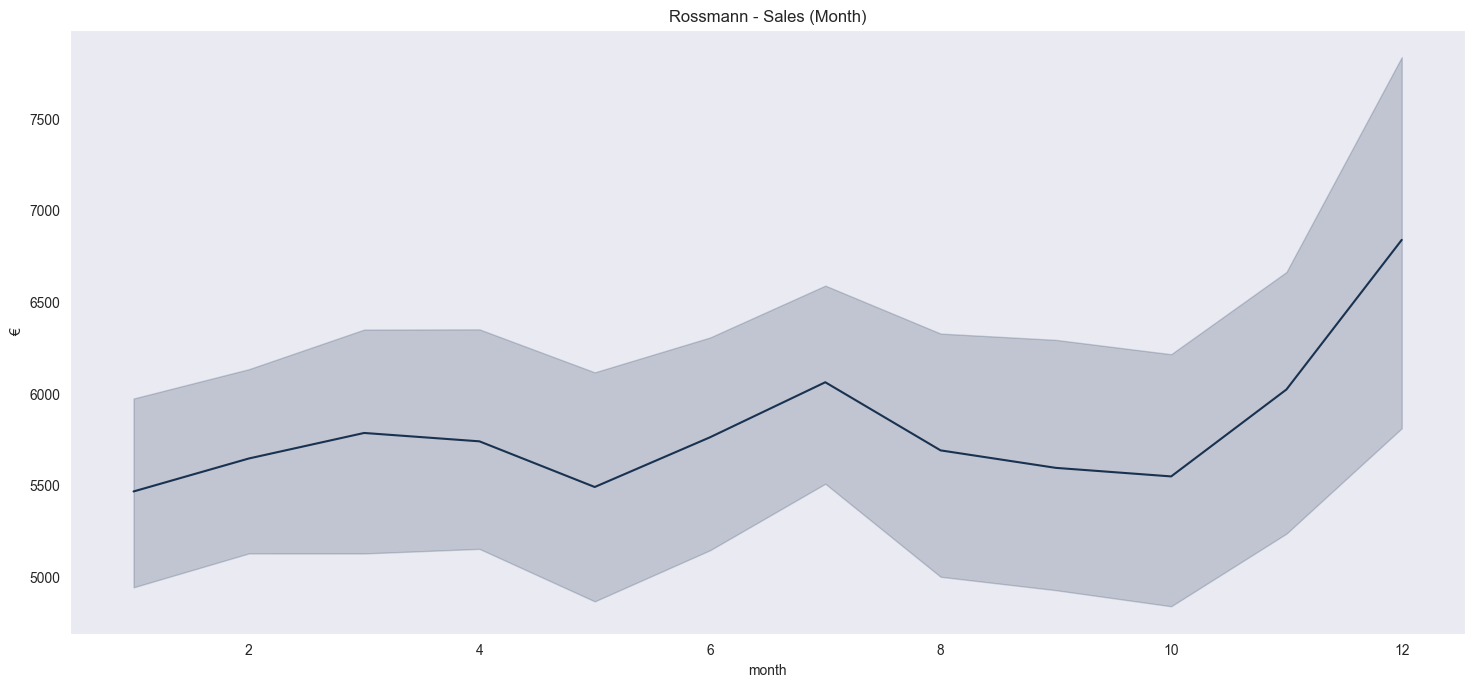

In [398]:
# Plot Sales on month basis 
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x='month', y='sales', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Rossmann - Sales (Month)', ylabel="€");

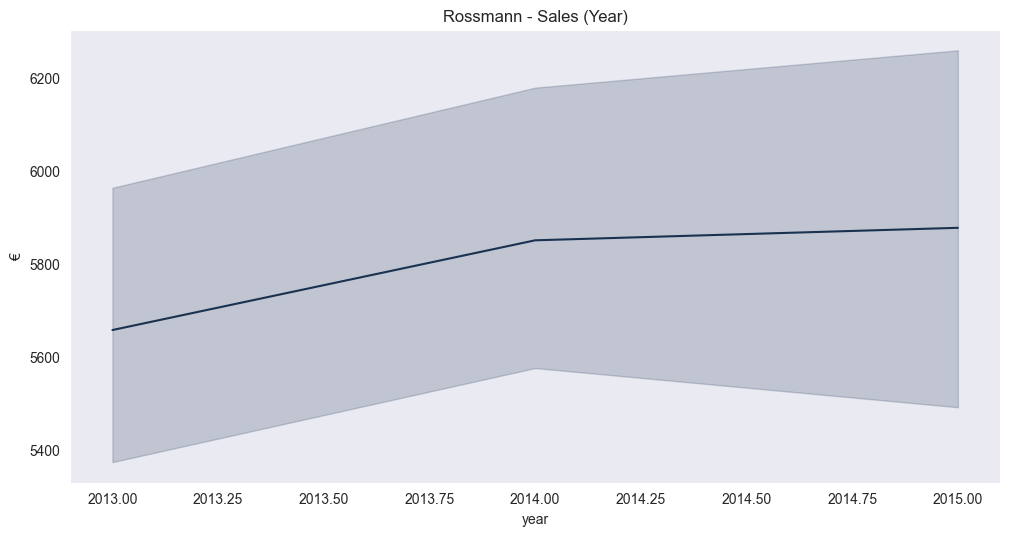

In [399]:
# Plot Sales on year basis 
fig, ax = plt.subplots()
sns.lineplot(x='year', y='sales', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Rossmann - Sales (Year)', ylabel="€");

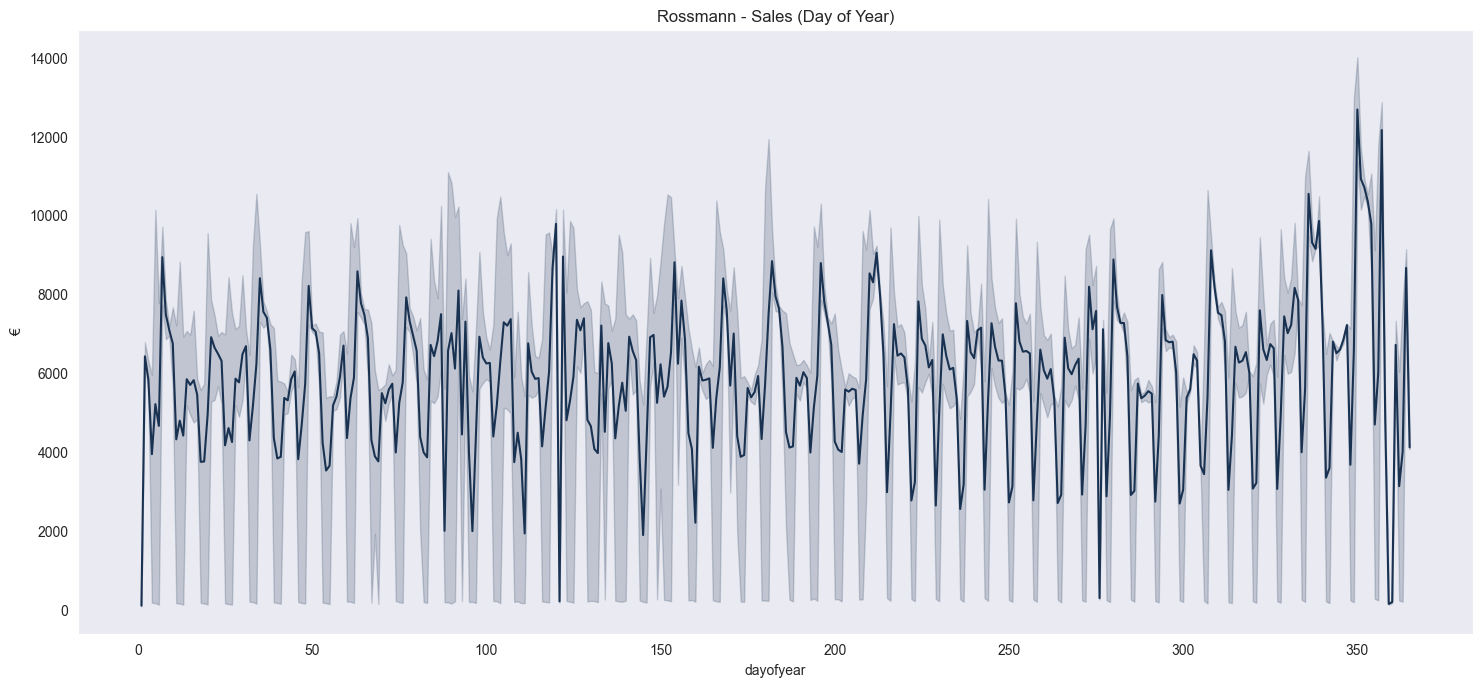

In [400]:
# Plot Sales on month basis 
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x='dayofyear', y='sales', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Rossmann - Sales (Day of Year)', ylabel="€");

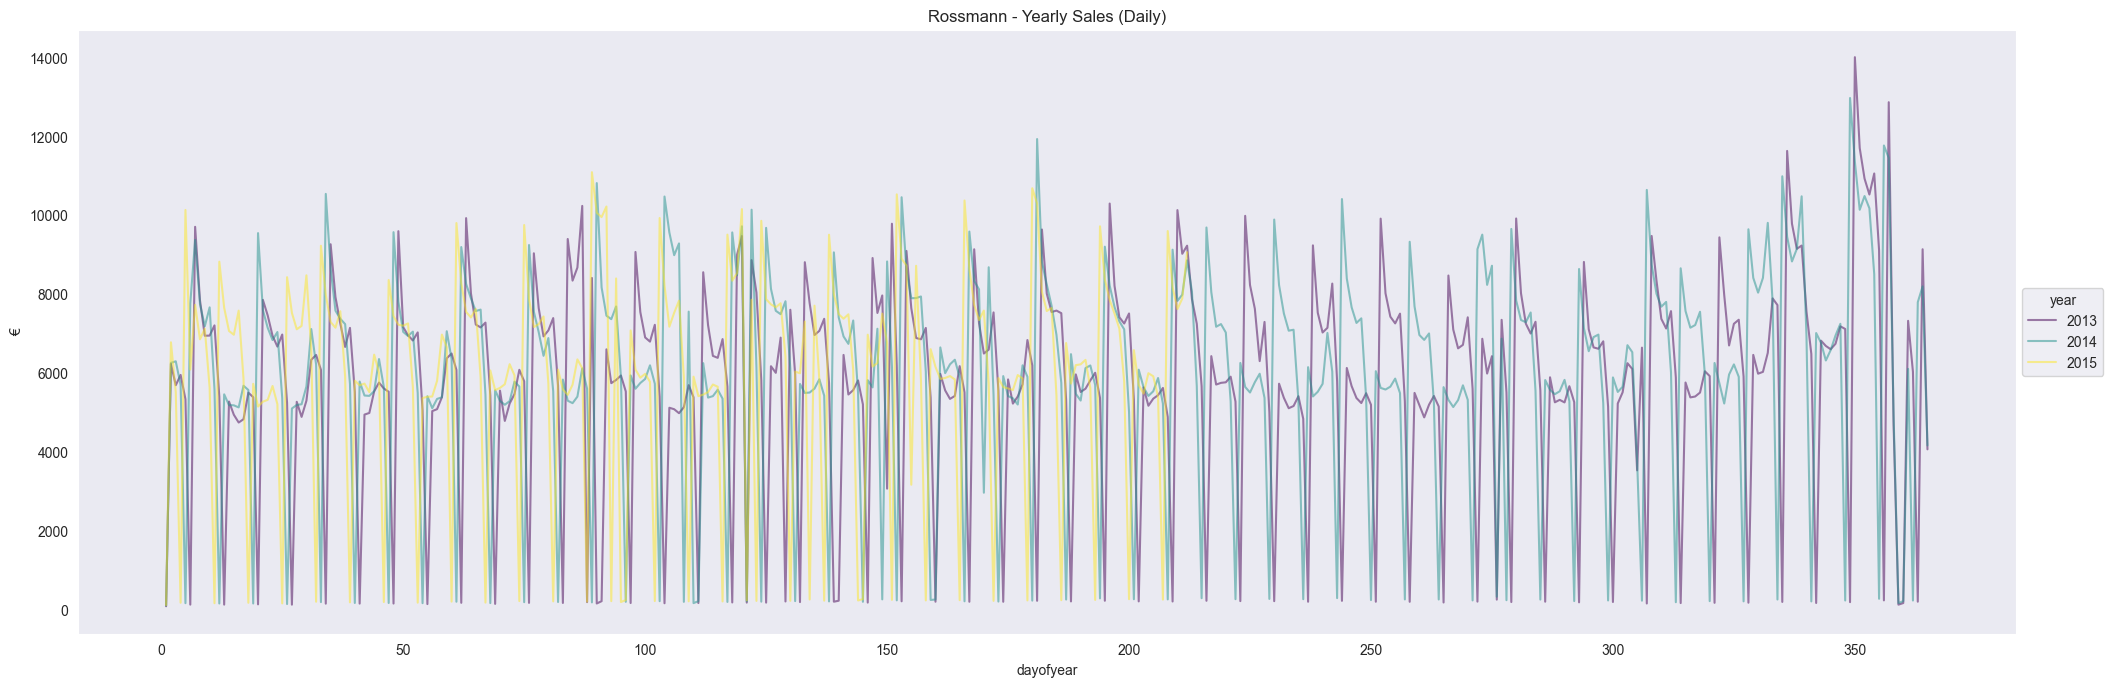

In [401]:
# Plot yearly seasonality
fig, ax = plt.subplots(figsize=(25,8)) 

pd.pivot_table(data=daily_data_df[['year', 'dayofyear', 'sales']], index='dayofyear', columns='year') \
    ['sales'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Rossmann - Yearly Sales (Daily)', ylabel="€");

# Smoothing

Usuall the first question of data analysis is "Can we extract general, global pattern here?" In time series with cyclic seasonal variation, 
this means that we want to smooth out this seasonality and let the global trend manifest itself. Most classical, first go-to way for this 
smoothing is to use Moving Average.

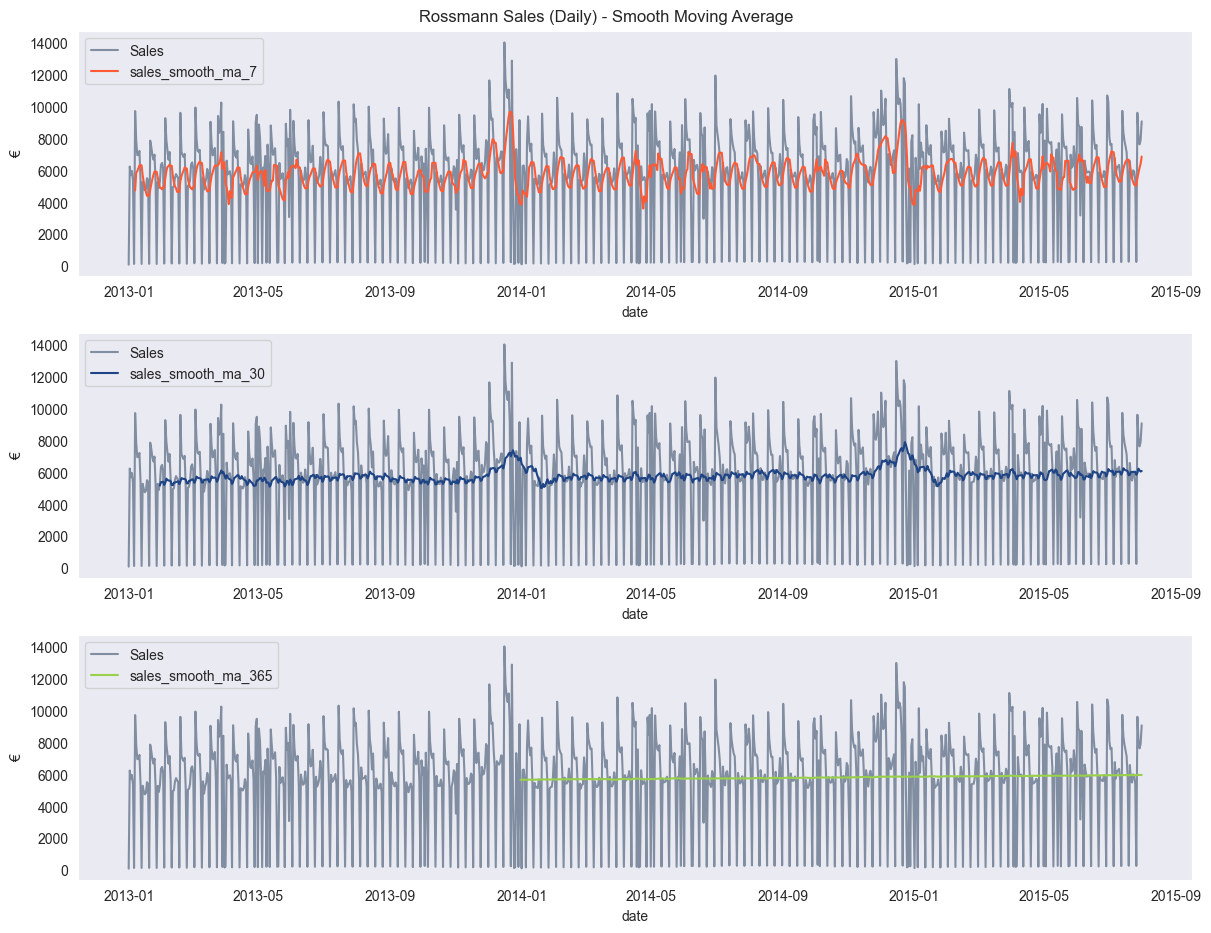

In [402]:
# Plot moving average of different length (week, month, year)
ma = [7, 30, 365]

smooth_daily_data_df = daily_data_df \
    .reset_index() \
    .assign(date = lambda x: x['date'].transform(pd.to_datetime))

# Smooth and plot
fig, ax = plt.subplots(3, 1, figsize=(12, 9), constrained_layout=True)

for i, m in enumerate(ma):

    smooth_daily_data_df[f'sales_smooth_ma_{m}'] = smooth_daily_data_df['sales'].rolling(window=m).mean()

    sns.lineplot(x='date', y='sales', label='Sales', data=smooth_daily_data_df, alpha=0.5, ax=ax[i])
    sns.lineplot(x='date', y=f'sales_smooth_ma_{m}', label=f'sales_smooth_ma_{m}', data=smooth_daily_data_df, color=sns_c[i + 1], ax=ax[i])
    ax[i].legend(loc='upper left')
    ax[i].set(title='', ylabel="€");

plt.suptitle('Rossmann Sales (Daily) - Smooth Moving Average', y=1.02);

Using the moving average of 365 units relfects the yearly structure of the data (lowest panel in the plot above).

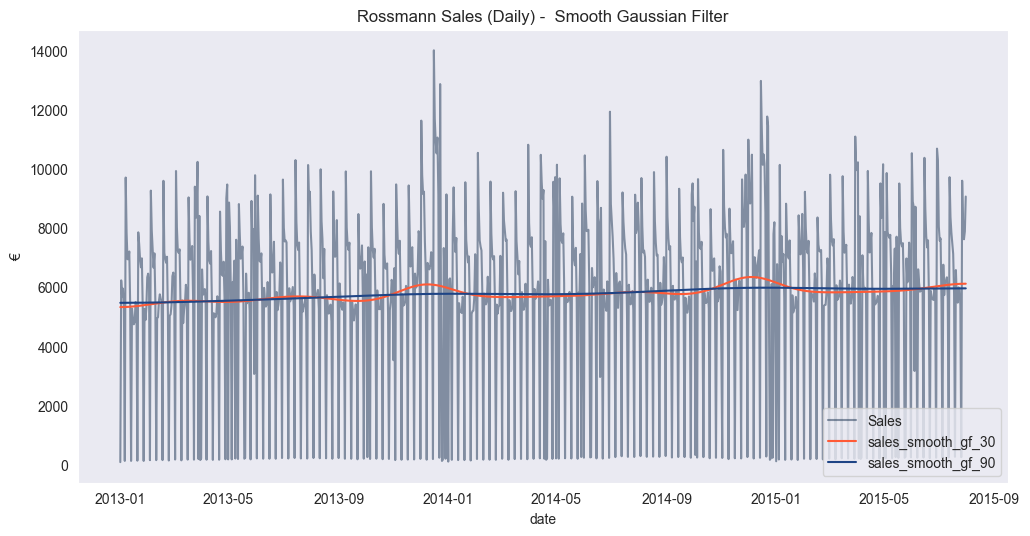

In [403]:
# Smooth data with gaussion filter
smooth_daily_data_df = smooth_daily_data_df \
    .assign(sales_smooth_gf_30 = lambda x: gaussian_filter(input=x['sales'], sigma=30)) \
    .assign(sales_smooth_gf_90 = lambda x: gaussian_filter(input=x['sales'], sigma=90))

# Plot data
fig, ax = plt.subplots()
sns.lineplot(x='date', y='sales', label='Sales', data=smooth_daily_data_df, alpha=0.5, ax=ax)
sns.lineplot(x='date', y='sales_smooth_gf_30', label='sales_smooth_gf_30', data=smooth_daily_data_df, color=sns_c[1], ax=ax)
sns.lineplot(x='date', y='sales_smooth_gf_90', label='sales_smooth_gf_90', data=smooth_daily_data_df, color=sns_c[2], ax=ax)
ax.legend(loc='lower right')
ax.set(title='Rossmann Sales (Daily) -  Smooth Gaussian Filter', ylabel="€");

Let us use this smoothing to plot again the seasonality yearly Sales:

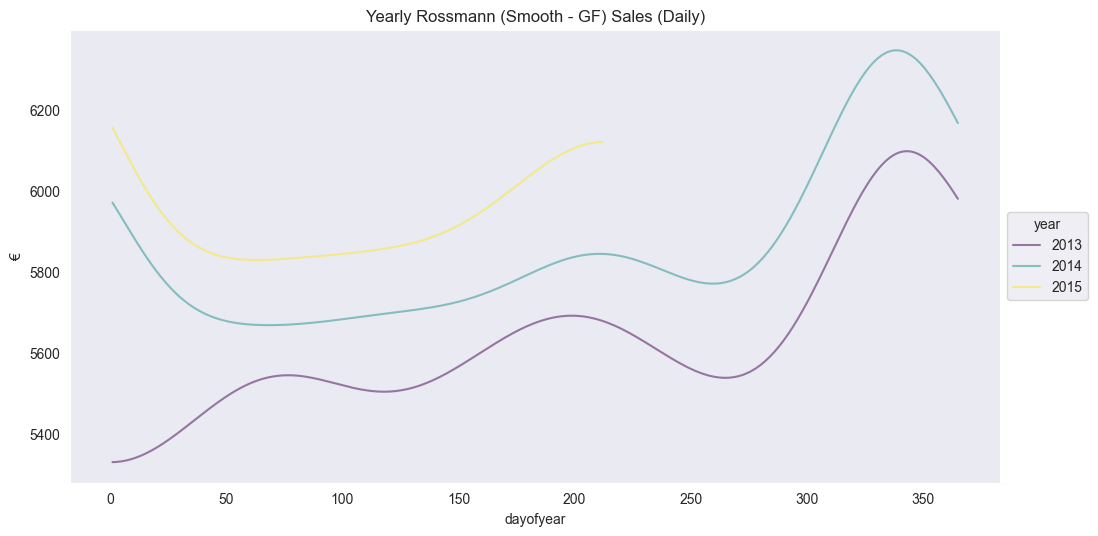

In [404]:
# Plot seasonal yearly sales 
fig, ax = plt.subplots() 

pd.pivot_table(data=smooth_daily_data_df[['year', 'dayofyear', 'sales_smooth_gf_30']], index='dayofyear', columns='year') \
    ['sales_smooth_gf_30'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Yearly Rossmann (Smooth - GF) Sales (Daily)', ylabel="€");

## Time Series Decomposition


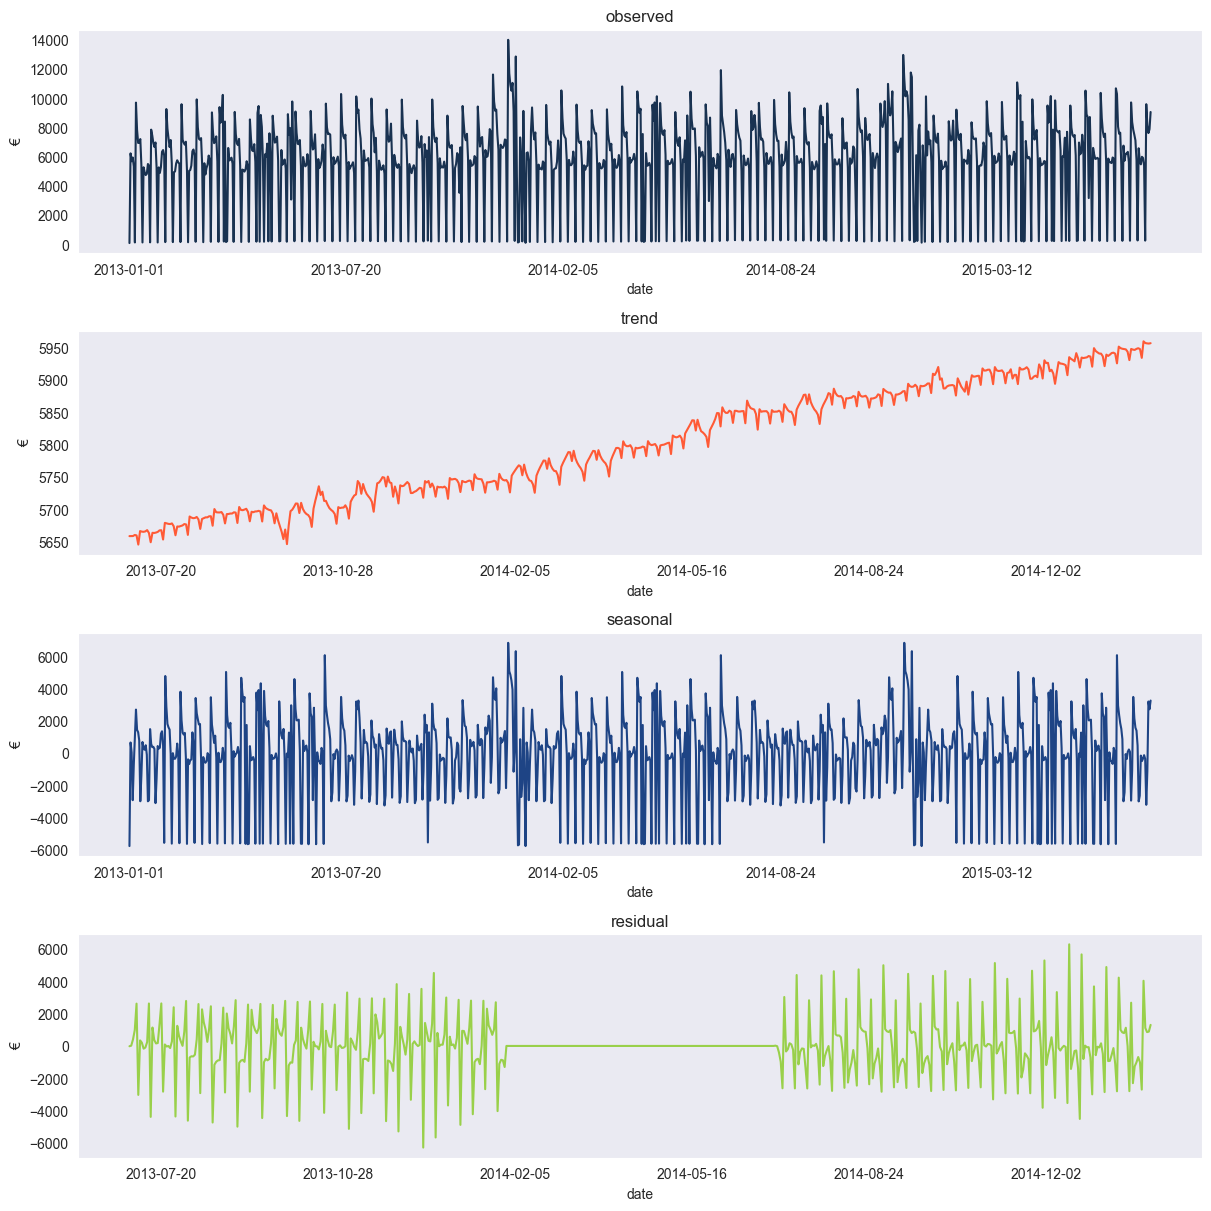

In [405]:
# We use the parameter `period` = 365 to extract the yearly seasonality. 
seas_decomp_yearly = seasonal_decompose(
    x=daily_data_df['sales'], 
    model='additive', 
    period=365
)

# Plot data
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel="€")
seas_decomp_yearly.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel="€")
seas_decomp_yearly.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel="€")
seas_decomp_yearly.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel="€");

We can now decompose the seasonal component from above. 

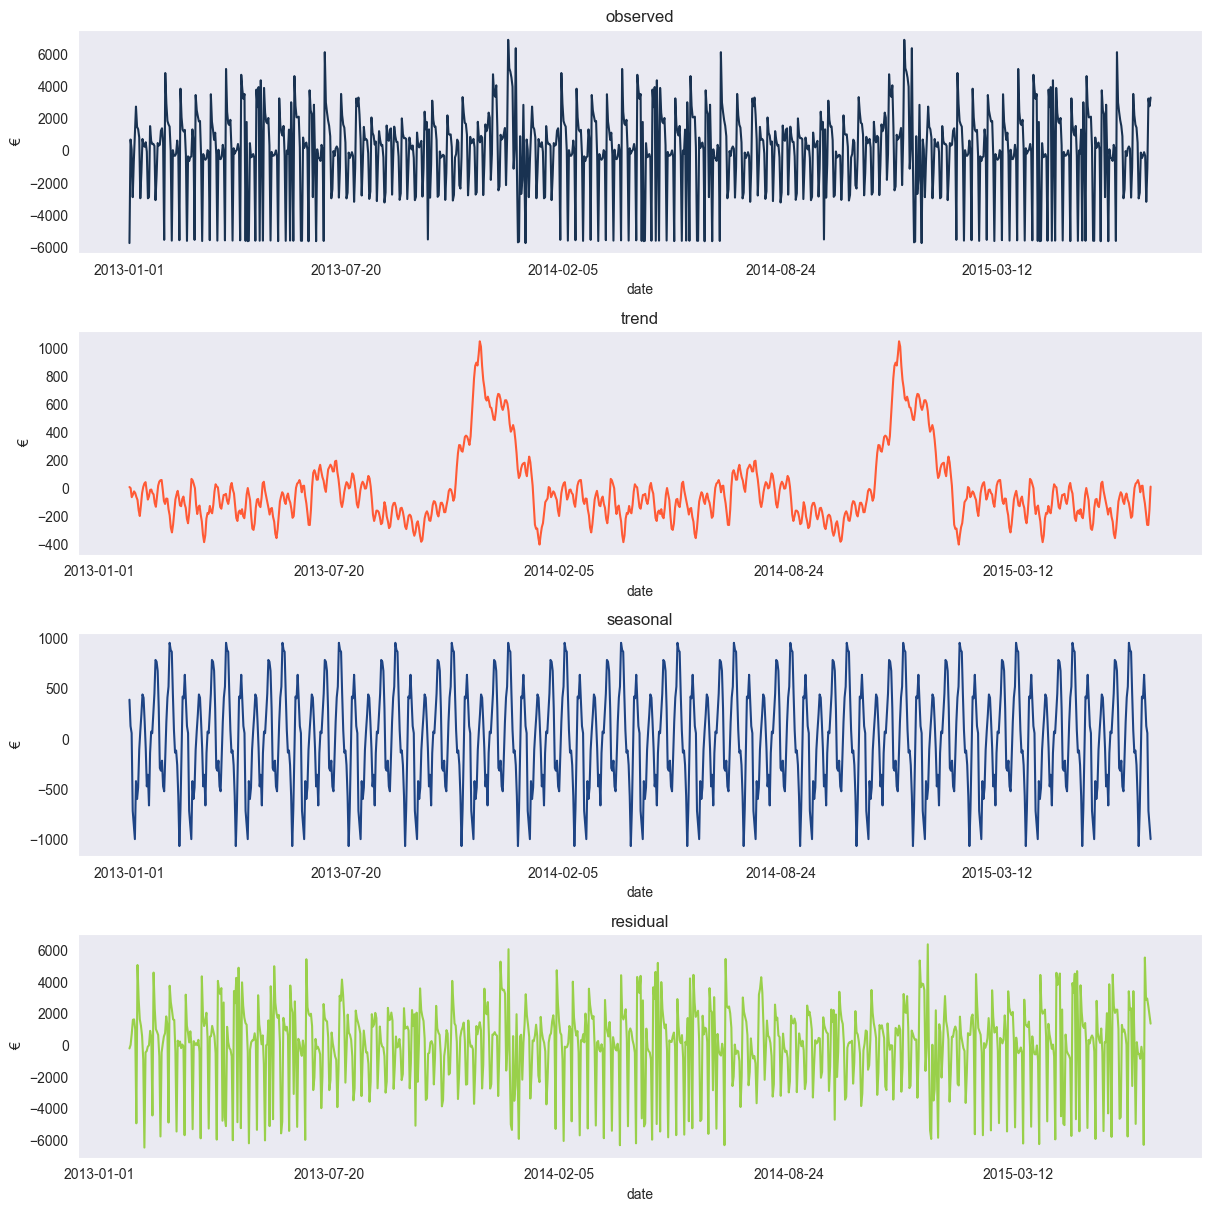

In [406]:
seas_decomp_monthly = seasonal_decompose(
    x=seas_decomp_yearly.seasonal, 
    model='additive', 
    period=52
)

# Plot data
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

seas_decomp_monthly.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel="€")
seas_decomp_monthly.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel="€")
seas_decomp_monthly.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel="€")
seas_decomp_monthly.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel="€");

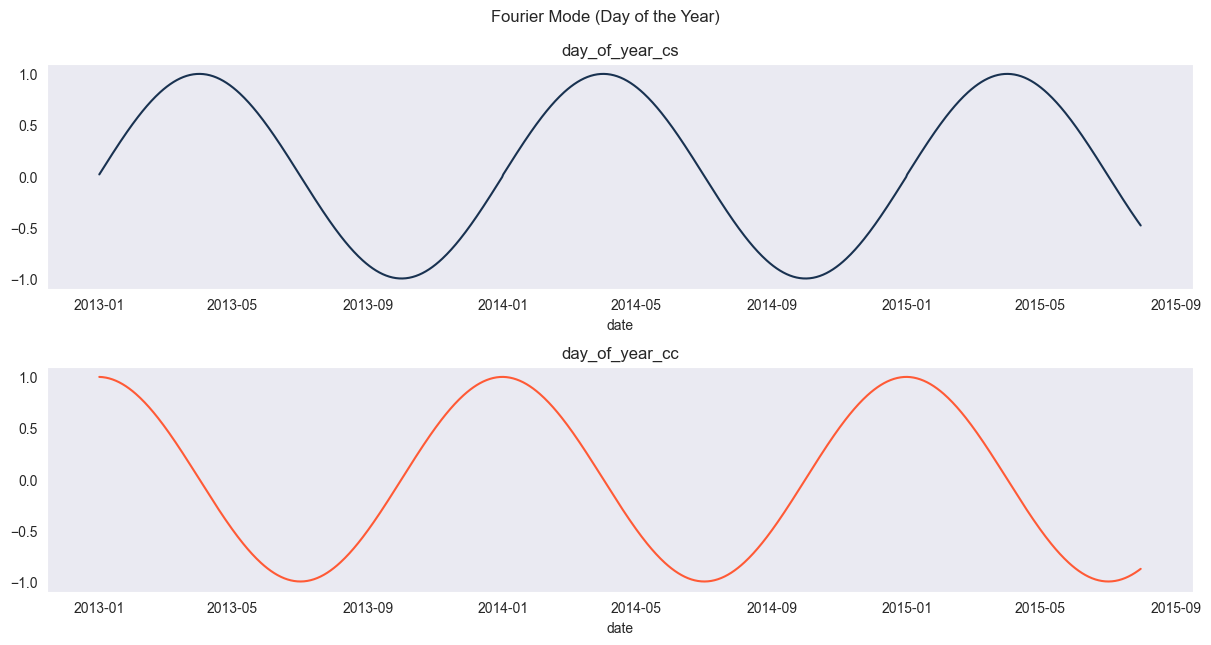

In [407]:
# Create linear trend and cyclical variables to model the day of the year. 
smooth_daily_data_df = smooth_daily_data_df.assign(
    index = lambda x: np.linspace(start=0, stop=x.shape[0]-1, num=x.shape[0]),
    day_of_year_cs = lambda x: np.sin(2*np.pi*x['dayofyear']/365.5),
    day_of_year_cc = lambda x: np.cos(2*np.pi*x['dayofyear']/365.5)
)

# Plot data
fig, ax = plt.subplots(2, 1, constrained_layout=True)
sns.lineplot(x='date', y='day_of_year_cs', data=smooth_daily_data_df, color=sns_c[0], ax=ax[0])
ax[0].set(title='day_of_year_cs', ylabel='')
sns.lineplot(x='date', y='day_of_year_cc', data=smooth_daily_data_df, color=sns_c[1], ax=ax[1])
ax[1].set(title='day_of_year_cc', ylabel='')
plt.suptitle('Fourier Mode (Day of the Year)', y=1.05);

Next, we use a linear model to fit each component:

In [408]:
# Define model
decomp_model = smf.ols(formula = 'sales ~ index + day_of_year_cs + day_of_year_cc', data=smooth_daily_data_df)

# Train model
decomp_red = decomp_model.fit()
print(decomp_red.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.365
Date:                Fri, 23 Jul 2021   Prob (F-statistic):              0.252
Time:                        08:39:33   Log-Likelihood:                -8840.4
No. Observations:                 942   AIC:                         1.769e+04
Df Residuals:                     938   BIC:                         1.771e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       5503.6398    189.532     29.

Finally, let us extract each component.

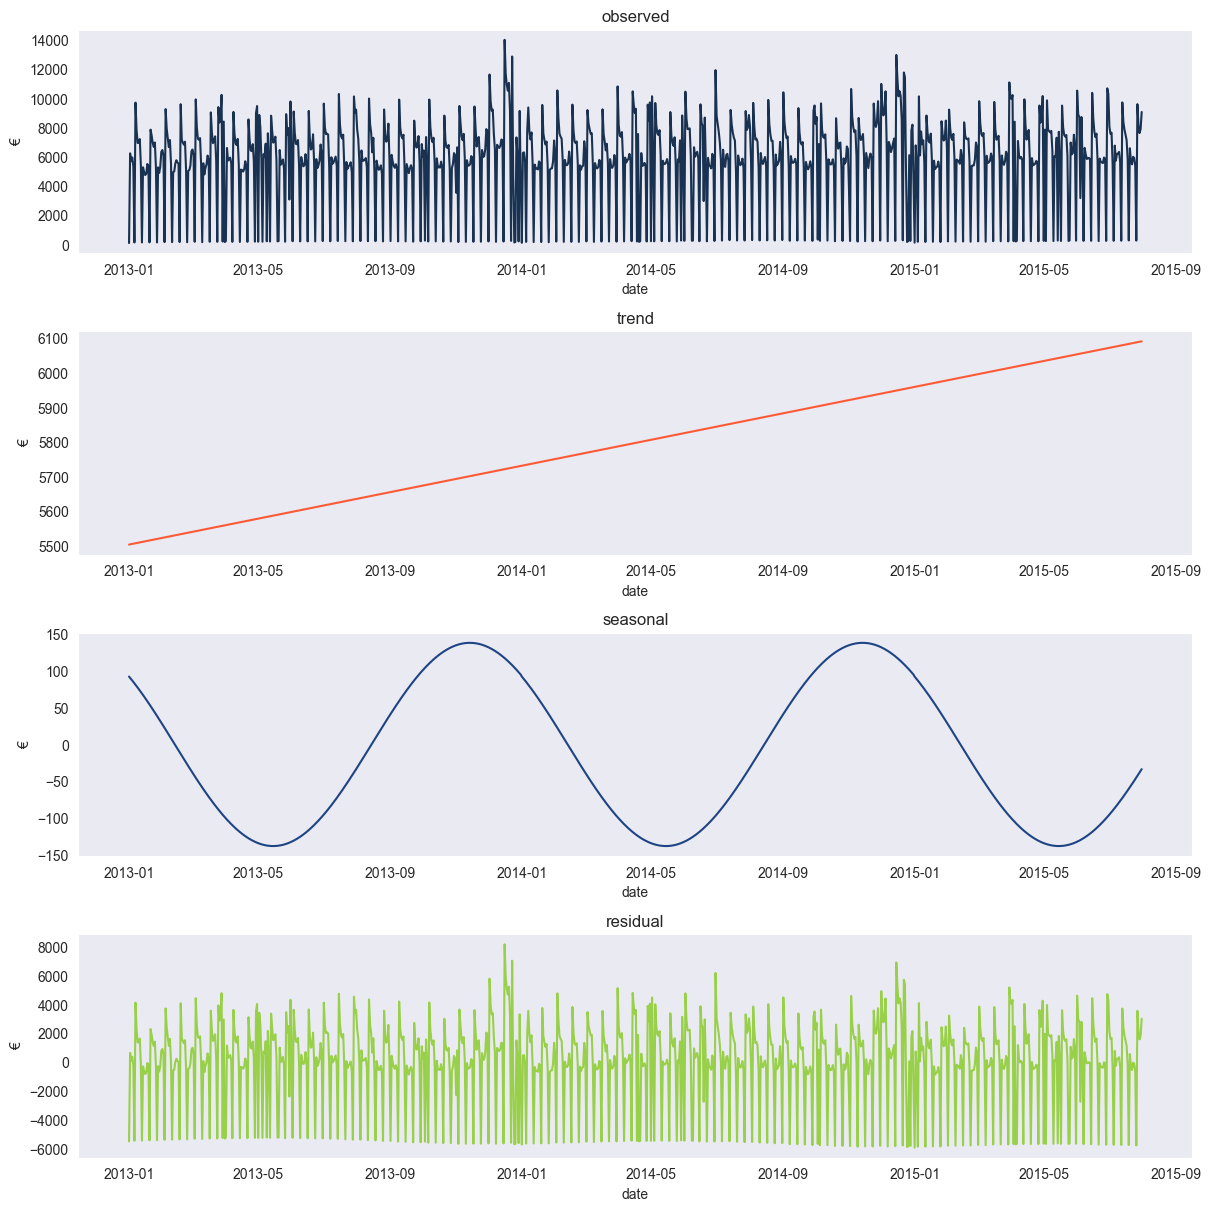

In [409]:
smooth_daily_data_df = smooth_daily_data_df.assign(
    decomp_trend = decomp_red.predict(smooth_daily_data_df.assign(day_of_year_cs = 0.0, day_of_year_cc = 0.0)),
    decomp_seas = decomp_red.predict(smooth_daily_data_df.assign(index = 0.0)) - decomp_red.params['Intercept'],
    decomp_error = lambda x: x['sales'] - x['decomp_trend'] - x['decomp_seas']
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

sns.lineplot(x='date', y='sales', data=smooth_daily_data_df, color=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel="€")

sns.lineplot(x='date', y='decomp_trend', data=smooth_daily_data_df, color=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel="€")

sns.lineplot(x='date', y='decomp_seas', data=smooth_daily_data_df, color=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel="€")

sns.lineplot(x='date', y='decomp_error', data=smooth_daily_data_df, color=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel="€");

#plt.savefig(f'../images/rossmann_daily_decomp_fourier.png', dpi=200, bbox_inches='tight');

## notebook 2

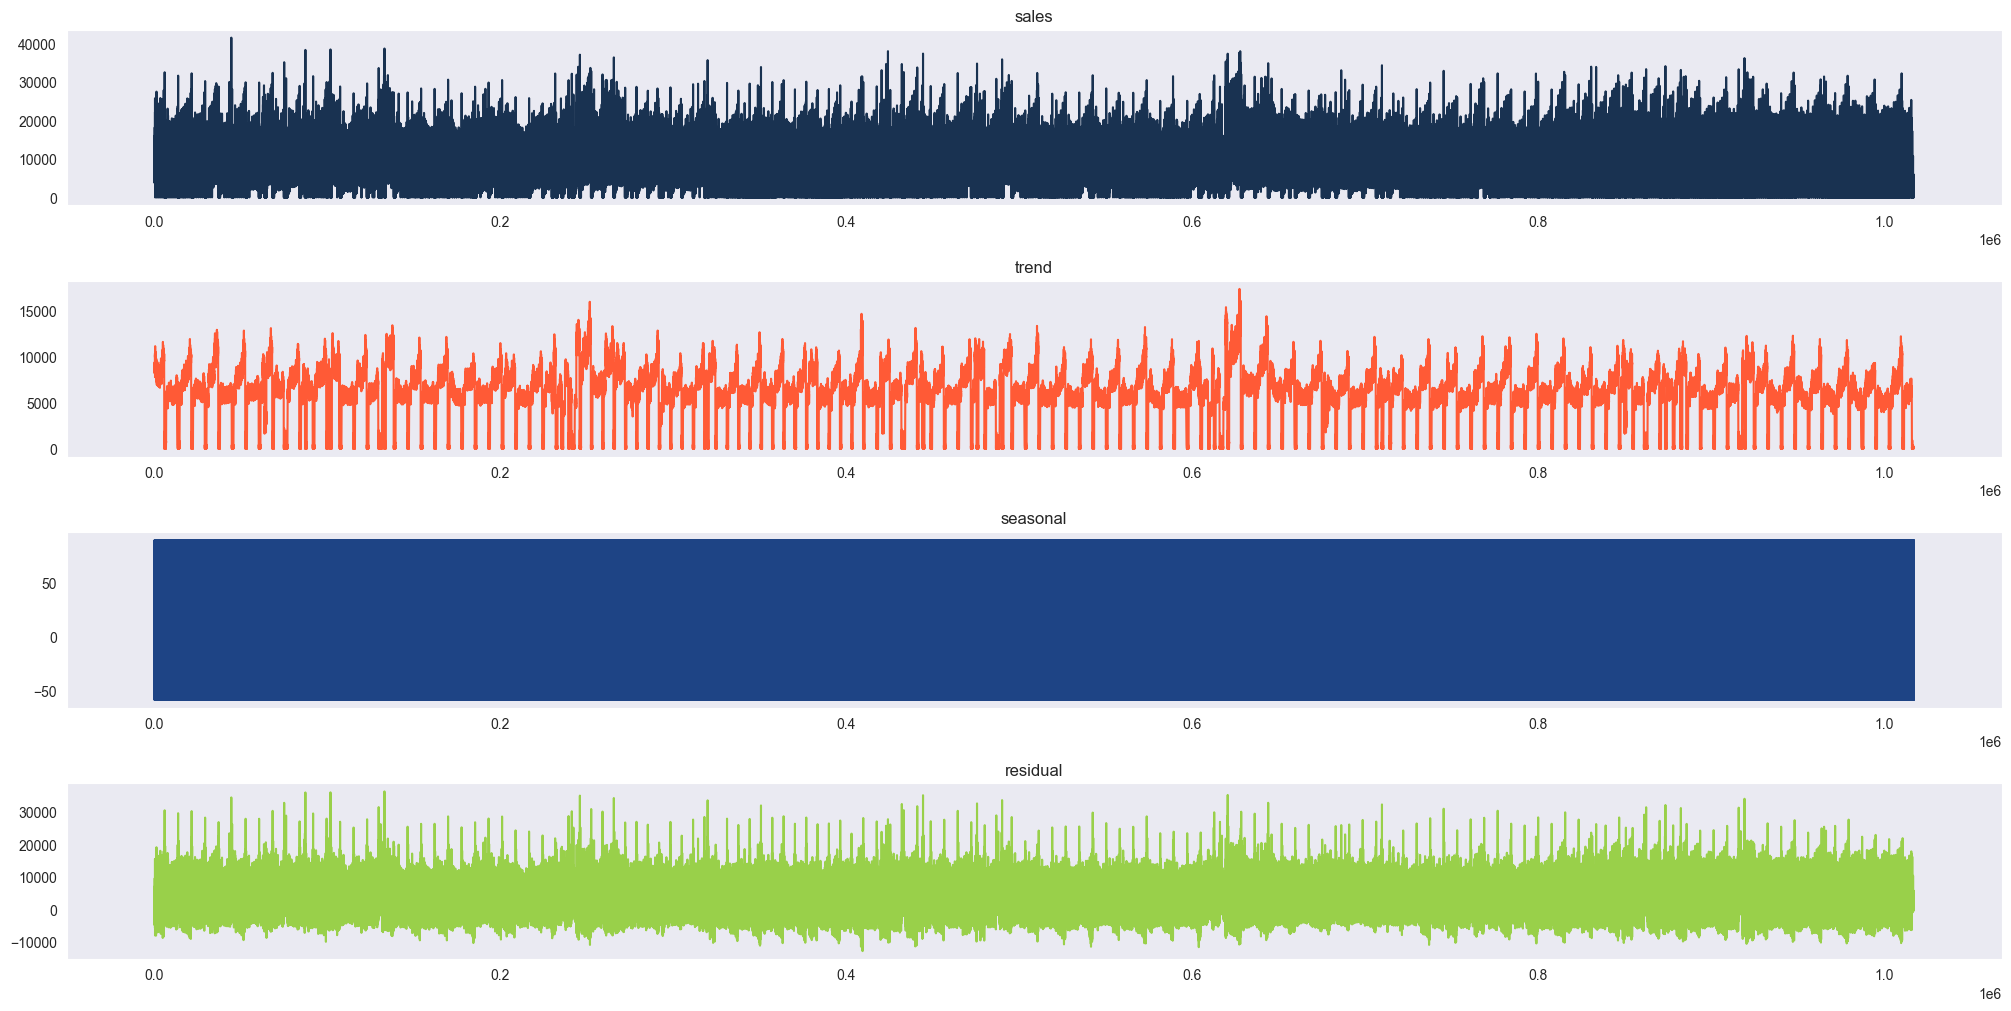

In [410]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=df['sales'], 
                                   model='additive',
                                   period=30)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='sales')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

The trend experienced some ups and downs as a sales generally does. We can conclude that (it is not seasonal as) the seasonality doesn't give any clear picture.
The variance of the resiudals remain relatively constant.

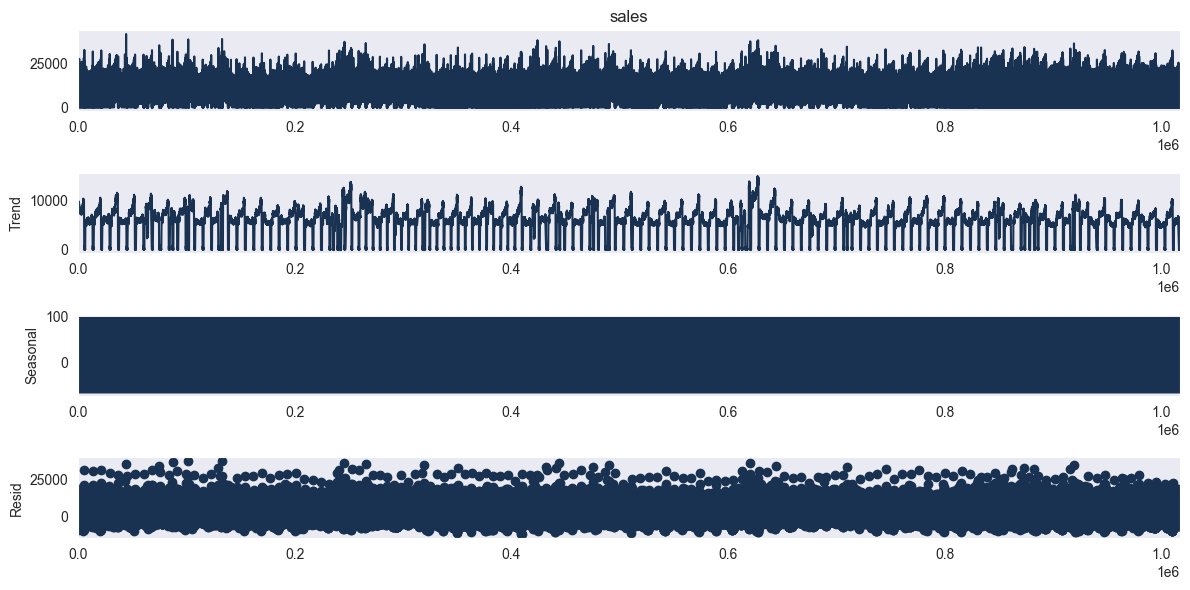

In [411]:
decomposition = sm.tsa.seasonal_decompose(x=df['sales'], model='additive',period = 100)
fig = decomposition.plot()
plt.show()


## De-trend the Time Series


# De-trending the time series
df['Sales_Detrend'] = (df['sales'] - df['sales'].shift(30))

# Test for stationarity after de-trending 
def stationarity_test(sales):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = sales.rolling(30).mean()
    rolling_std_dev = sales.rolling(30).std()
  
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, label='Rolling Mean',linewidth=2.0)
    plt.plot(rolling_std_dev, label = 'Rolling Std Dev',linewidth=2.0)
    plt.plot(sales,label='De-Trended Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.tight_layout()
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(sales,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(sales, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df['Sales_Detrend'].dropna())

 Partial Autocorrelation Plot
pacf = plot_pacf(df['Sales_Detrend'].dropna(), lags=30)

In [679]:
df_ts = df.drop(["date","stateholiday","storetype", "promointerval","assortment"],axis=1)

In [680]:
df["timestamp"].nunique()

942

In [681]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   sales                      1017209 non-null  int64         
 3   customers                  1017209 non-null  int64         
 4   open                       1017209 non-null  int64         
 5   promo                      1017209 non-null  int64         
 6   schoolholiday              1017209 non-null  int64         
 7   competitiondistance        1017209 non-null  float64       
 8   competitionopensincemonth  1017209 non-null  float64       
 9   competitionopensinceyear   1017209 non-null  float64       
 10  promo2                     1017209 non-null  int64         
 11  promo2sinceweek            1017209 no

In [682]:
df_test.drop(["Date","StateHoliday"], axis=1 , inplace=True)

In [683]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                41088 non-null  int64         
 1   Store             41088 non-null  int64         
 2   DayOfWeek         41088 non-null  int64         
 3   Open              41088 non-null  int64         
 4   Promo             41088 non-null  int64         
 5   SchoolHoliday     41088 non-null  int64         
 6   timestamp         41088 non-null  datetime64[ns]
 7   year              41088 non-null  int64         
 8   month             41088 non-null  int64         
 9   day               41088 non-null  int64         
 10  dayofyear         41088 non-null  int64         
 11  StateHoliday_cat  41088 non-null  int64         
dtypes: datetime64[ns](1), int64(11)
memory usage: 3.8 MB


In [684]:
df_test["timestamp"].max()

Timestamp('2015-09-17 00:00:00')

In [685]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                41088 non-null  int64         
 1   Store             41088 non-null  int64         
 2   DayOfWeek         41088 non-null  int64         
 3   Open              41088 non-null  int64         
 4   Promo             41088 non-null  int64         
 5   SchoolHoliday     41088 non-null  int64         
 6   timestamp         41088 non-null  datetime64[ns]
 7   year              41088 non-null  int64         
 8   month             41088 non-null  int64         
 9   day               41088 non-null  int64         
 10  dayofyear         41088 non-null  int64         
 11  StateHoliday_cat  41088 non-null  int64         
dtypes: datetime64[ns](1), int64(11)
memory usage: 3.8 MB


In [686]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Store             1017209 non-null  int64         
 1   DayOfWeek         1017209 non-null  int64         
 2   Date              1017209 non-null  object        
 3   Sales             1017209 non-null  int64         
 4   Customers         1017209 non-null  int64         
 5   Open              1017209 non-null  int64         
 6   Promo             1017209 non-null  int64         
 7   StateHoliday      1017209 non-null  object        
 8   SchoolHoliday     1017209 non-null  int64         
 9   timestamp         1017209 non-null  datetime64[ns]
 10  year              1017209 non-null  int64         
 11  month             1017209 non-null  int64         
 12  day               1017209 non-null  int64         
 13  dayofyear         1017209 non-null  int64 

In [687]:
train_data= train_data.drop(["Date","StateHoliday"], axis=1)

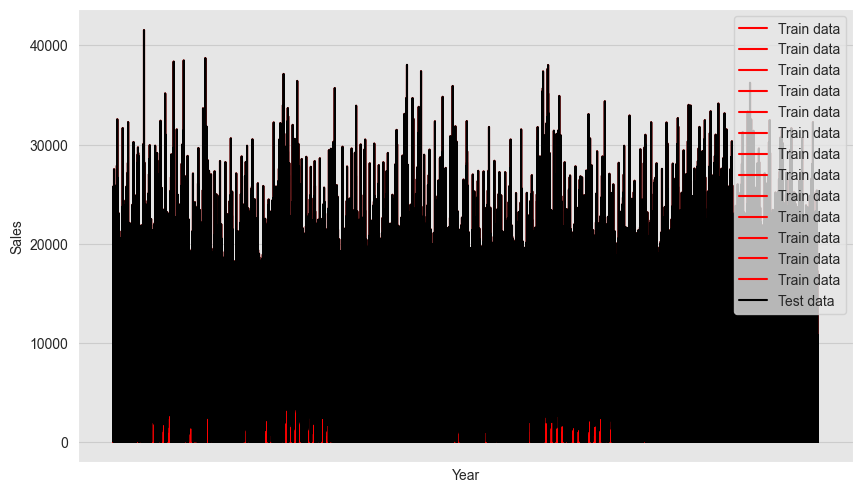

In [688]:

# Split data into train and test set
df_arima = df_ts['sales']


# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Sales')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(df_arima, 'black', label='Test data')
plt.legend();

In [421]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                41088 non-null  int64         
 1   Store             41088 non-null  int64         
 2   DayOfWeek         41088 non-null  int64         
 3   Open              41088 non-null  int64         
 4   Promo             41088 non-null  int64         
 5   SchoolHoliday     41088 non-null  int64         
 6   timestamp         41088 non-null  datetime64[ns]
 7   year              41088 non-null  int64         
 8   month             41088 non-null  int64         
 9   day               41088 non-null  int64         
 10  dayofyear         41088 non-null  int64         
 11  StateHoliday_cat  41088 non-null  int64         
dtypes: datetime64[ns](1), int64(11)
memory usage: 3.8 MB


In [422]:
# Autocorrelation function to make ACF and PACF graphs
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)),linestyle='--',color ='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)),linestyle='--',color ='red')
    plt.title('PACF')

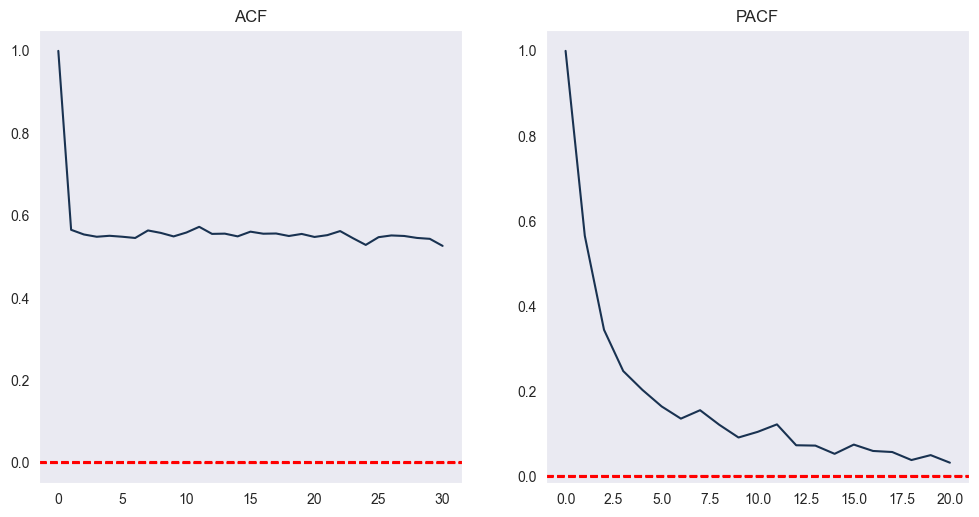

In [423]:
# ACF and PACF for sales
auto_corr(df["sales"])

Due to their opposite behavior for AR and MA processes, a combination of ACF and PACF plots can be used to identify both p and q for an ARMA process.
In such a case, the PACF identifies p and ACF identifies the q order of the ARMA process.

In [424]:
df_test

Id  Store  DayOfWeek  Open  Promo  SchoolHoliday  timestamp  year  \
0          1      1          4     1      1              0 2015-09-17  2015   
1          2      3          4     1      1              0 2015-09-17  2015   
2          3      7          4     1      1              0 2015-09-17  2015   
3          4      8          4     1      1              0 2015-09-17  2015   
4          5      9          4     1      1              0 2015-09-17  2015   
...      ...    ...        ...   ...    ...            ...        ...   ...   
41083  41084   1111          6     1      0              0 2015-08-01  2015   
41084  41085   1112          6     1      0              0 2015-08-01  2015   
41085  41086   1113          6     1      0              0 2015-08-01  2015   
41086  41087   1114          6     1      0              0 2015-08-01  2015   
41087  41088   1115          6     1      0              1 2015-08-01  2015   

       month  day  dayofyear  StateHoliday_cat  
0          9   17        260                 0  
1          9   17        260                 0  
2          9   17        260                 0  
3          9   17        260                 0  
4          9   17        260                 0  
...      ...  ...        ...               ...  
41083      8    1        213                 0  
41084      8    1        213                 0  
41085      8    1        213                 0  
41086      8    1        213                 0  
41087      8    1        213                 0  

[41088 rows x 12 columns]

In [425]:
df_train.head(20)

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0       1          5  2015-07-31   5263        555     1      1            0   
1       2          5  2015-07-31   6064        625     1      1            0   
2       3          5  2015-07-31   8314        821     1      1            0   
3       4          5  2015-07-31  13995       1498     1      1            0   
4       5          5  2015-07-31   4822        559     1      1            0   
5       6          5  2015-07-31   5651        589     1      1            0   
6       7          5  2015-07-31  15344       1414     1      1            0   
7       8          5  2015-07-31   8492        833     1      1            0   
8       9          5  2015-07-31   8565        687     1      1            0   
9      10          5  2015-07-31   7185        681     1      1            0   
10     11          5  2015-07-31  10457       1236     1      1            0   
11     12          5  2015-07-31   8959        962     1      1            0   
12     13          5  2015-07-31   8821        568     1      1            0   
13     14          5  2015-07-31   6544        710     1      1            0   
14     15          5  2015-07-31   9191        766     1      1            0   
15     16          5  2015-07-31  10231        979     1      1            0   
16     17          5  2015-07-31   8430        946     1      1            0   
17     18          5  2015-07-31  10071        936     1      1            0   
18     19          5  2015-07-31   8234        718     1      1            0   
19     20          5  2015-07-31   9593        974     1      1            0   

    SchoolHoliday  
0               1  
1               1  
2               1  
3               1  
4               1  
5               1  
6               1  
7               1  
8               1  
9               1  
10              1  
11              1  
12              0  
13              1  
14              1  
15              1  
16              1  
17              1  
18              1  
19              0

# Auto ARIMA Method
arima_model = auto_arima(df_arima,
                      random=True,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = True,
                      stationary= True,
                         n_jobs=-1
                      
                      )



# Fit the final model with the order
fitted_model = arima_model.fit(df_ts) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(df_ts), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_ts, label='training')
plt.plot(df_test, label='Actual Sales ')
plt.plot(fcv_series,label='Predicted Sales')
plt.title('Sales Prediction')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(df_test.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

In [436]:
# Prophet

In [689]:
df_ts["timestamp"].nunique()

942

In [690]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   sales                      1017209 non-null  int64         
 3   customers                  1017209 non-null  int64         
 4   open                       1017209 non-null  int64         
 5   promo                      1017209 non-null  int64         
 6   schoolholiday              1017209 non-null  int64         
 7   competitiondistance        1017209 non-null  float64       
 8   competitionopensincemonth  1017209 non-null  float64       
 9   competitionopensinceyear   1017209 non-null  float64       
 10  promo2                     1017209 non-null  int64         
 11  promo2sinceweek            1017209 no

In [691]:
df_prophet = df_ts.drop(["salepercustomer","stateholiday_cat","storetype_cat","ass_extended","ass_extra", \
                         "dayofyear","day","month","year","promo2sinceyear","promo2sinceweek","promo2","competitionopensinceyear", \
                         "competitionopensincemonth","competitiondistance","schoolholiday","promo","open","customers","dayofweek","store"],axis=1)

In [692]:
df_prophet.columns = ["y","ds"]
df_prophet = df_prophet[["ds","y"]]

In [693]:
df_prophet.head()

ds      y
0 2015-07-31   5263
1 2015-07-31   6064
2 2015-07-31   8314
3 2015-07-31  13995
4 2015-07-31   4822

In [694]:
df_prophet = df_prophet.sort_index(ascending =False)

In [695]:
df_prophet["ds"].nunique()

942

In [696]:
df_prophet.head()

ds  y
1017208 2013-01-01  0
1017207 2013-01-01  0
1017206 2013-01-01  0
1017205 2013-01-01  0
1017204 2013-01-01  0

## Prophet
- By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward
  and to avoid overfitting fluctuations at the end of the time series. This default works in many situations but not all, and can be changed using
  the changepoint_range argument. For example, m = Prophet(changepoint_range=0.9)
 
- Adjusting trend flexibility: If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength  of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible. Example: m = Prophet(changepoint_prior_scale=0.5)

- If you wish, rather than using automatic changepoint detection you can manually specify the locations of potential changepoints with the changepoints argument. Slope changes will then be allowed only at these points, with the same sparse regularization as before. One could, for instance, create a grid of points as is done automatically, but then augment that grid with some specific dates that are known to be likely to have changes. As another example, the changepoints could be entirely limited to a small set of dates, as is done here: m = Prophet(changepoints=['2014-01-01'])

- Modeling Holidays and Special Events: If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them. It has two columns (holiday and ds) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won’t repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns lower_window and upper_window which extend the holiday out to [lower_window, upper_window] days around the date. For instance, if you wanted to include Christmas Eve in addition to Christmas you’d include lower_window=-1,upper_window=0. If you wanted to use Black Friday in addition to Thanksgiving, you’d include lower_window=0,upper_window=1. You can also include a column prior_scale to set the prior scale separately for each holiday, as described below.

Example: 

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

Above we have included the superbowl days as both playoff games and superbowl games. This means that the superbowl effect will be an additional additive bonus on top of the playoff effect.

Once the table is created, holiday effects are included in the forecast by passing them in with the holidays argument. Here we do it with the Peyton Manning data from the Quickstart:  m = Prophet(holidays=holidays)
                           forecast = m.fit(df).predict(future)

The holiday effect can be seen in the forecast dataframe: forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
                                                                  ['ds', 'playoff', 'superbowl']][-10:]
                                                                  
The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl

Individual holidays can be plotted using the plot_forecast_component function (imported from prophet.plot in Python) like plot_forecast_component(m, forecast, 'superbowl') to plot just the superbowl holiday component.

- Built-in Country Holidays: You can use a built-in collection of country-specific holidays using the add_country_holidays method (Python) or function (R). The   name of the country is specified, and then major holidays for that country will be included in addition to any holidays that are specified via the holidays     argument described above:

m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)

The holidays for each country are provided by the holidays package in Python. A list of available countries, and the country name to use, is available on their page: https://github.com/dr-prodigy/python-holidays. In addition to those countries, Prophet includes holidays for these countries: Brazil (BR), Indonesia (ID), India (IN), Malaysia (MY), Vietnam (VN), Thailand (TH), Philippines (PH), Pakistan (PK), Bangladesh (BD), Egypt (EG), China (CN), and Russian (RU), Korea (KR), Belarus (BY), and United Arab Emirates (AE).

- Fourier Order for Seasonalities: Seasonalities are estimated using a partial Fourier sum.The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change.

The default values are often appropriate, but they can be increased when the seasonality needs to fit higher-frequency changes, and generally be less smooth. The Fourier order can be specified for each built-in seasonality when instantiating the model, here it is increased to 20: 
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting: N Fourier terms corresponds to 2N variables used for modeling the cycle

- Specifying Custom Seasonalities: Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the add_seasonality method (Python).
The inputs to this function are a name, the period of the seasonality in days, and the Fourier order for the seasonality. For reference, by default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality. An optional input to add_seasonality is the prior scale for that seasonal component - this is discussed below.

m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

- Seasonalities that depend on other factors: In some instances the seasonality may depend on other factors, such as a weekly seasonal pattern that is different during the summer than it is during the rest of the year, or a daily seasonal pattern that is different on weekends vs. on weekdays. These types of seasonalities can be modeled using conditional seasonalities.

Consider the Peyton Manning example from the Quickstart. The default weekly seasonality assumes that the pattern of weekly seasonality is the same throughout the year, but we’d expect the pattern of weekly seasonality to be different during the on-season (when there are games every Sunday) and the off-season. We can use conditional seasonalities to construct separate on-season and off-season weekly seasonalities.

First we add a boolean column to the dataframe that indicates whether each date is during the on-season or the off-season:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

df['on_season'] = df['ds'].apply(is_nfl_season)
df['off_season'] = ~df['ds'].apply(is_nfl_season)

Then we disable the built-in weekly seasonality, and replace it with two weekly seasonalities that have these columns specified as a condition. This means that the seasonality will only be applied to dates where the condition_name column is True. We must also add the column to the future dataframe for which we are making predictions.

m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')

future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

Both of the seasonalities now show up in the components plots above. We can see that during the on-season when games are played every Sunday, there are large increases on Sunday and Monday that are completely absent during the off-season.

- Prior scale for holidays and seasonality: If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using the parameter holidays_prior_scale. By default this parameter is 10, which provides very little regularization. Reducing this parameter dampens holiday effects:

m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]
    
The magnitude of the holiday effect has been reduced compared to before, especially for superbowls, which had the fewest observations. There is a parameter seasonality_prior_scale which similarly adjusts the extent to which the seasonality model will fit the data.
Prior scales can be set separately for individual holidays by including a column prior_scale in the holidays dataframe. Prior scales for individual seasonalities can be passed as an argument to add_seasonality. For instance, the prior scale for just weekly seasonality can be set using:

m = Prophet()
m.add_seasonality(
    name='weekly', period=7, fourier_order=3, prior_scale=0.1)



In [443]:
m =Prophet()

In [467]:
df_prophet.shape

(1017209, 2)

In [470]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 1017208 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   ds      1017209 non-null  datetime64[ns]
 1   y       1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 23.3 MB


In [444]:
model_prophet= m.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [511]:
future_sales= m.make_future_dataframe(periods=48, freq="D",include_history =True)
forecast_sales= m.predict(future_sales)
forecast_sales.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2013-01-01  5610.085430  2108.691184  9964.732988  5610.085430  5610.085430   
1 2013-01-02  5613.002313  1753.590141  9482.860718  5613.002313  5613.002313   
2 2013-01-03  5615.919196  1420.527708  9178.103490  5615.919196  5615.919196   
3 2013-01-04  5618.836078  2049.784999  9684.730466  5618.836078  5618.836078   
4 2013-01-05  5621.752961   824.903438  8382.890701  5621.752961  5621.752961   

   additive_terms  additive_terms_lower  additive_terms_upper       weekly  \
0      516.914913            516.914913            516.914913  1237.254728   
1       21.658039             21.658039             21.658039   786.645575   
2     -319.436354           -319.436354           -319.436354   477.481634   
3      135.338092            135.338092            135.338092   951.709821   
4     -745.882023           -745.882023           -745.882023    77.934178   

   weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0   1237.254728   1237.254728 -720.339815   -720.339815   -720.339815   
1    786.645575    786.645575 -764.987536   -764.987536   -764.987536   
2    477.481634    477.481634 -796.917988   -796.917988   -796.917988   
3    951.709821    951.709821 -816.371729   -816.371729   -816.371729   
4     77.934178     77.934178 -823.816201   -823.816201   -823.816201   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  6127.000343  
1                         0.0  5634.660352  
2                         0.0  5296.482842  
3                         0.0  5754.174170  
4                         0.0  4875.870939

In [510]:
forecast_sales.shape

(984, 19)

In [482]:
proph_evu= forecast_sales["yhat"]
#proph_evu.columns =["Sales"]
#proph_evu= pd.DataFrame(forecast_sales["yhat"],columns= ["Sales"])
proph_evu.rename("Sales", inplace=True)

0      6127.000343
1      5634.660352
2      5296.482842
3      5754.174170
4      4875.870939
          ...     
985     290.507424
986    7902.503864
987    7113.495122
988    6673.241432
989    6374.383707
Name: Sales, Length: 990, dtype: float64

In [810]:
rmse(proph_evu,y_test)

44.34869877301104

In [483]:
proph_evu.describe()

count     990.000000
mean     5796.845975
std      2377.856958
min      -762.384506
25%      5876.521780
50%      6495.237053
75%      6993.779391
max      9685.886949
Name: Sales, dtype: float64

In [484]:
proph_evu.shape

(990,)

In [279]:
#df_sample_submission.drop(["Sales"], axis=1, inplace=True)

In [499]:
df_submission_fbp1 = pd.concat([df_sample_submission,proph_evu], axis=1,join="outer")

In [503]:
df_submission_fbp1

key_0     Id  Sales_x      Sales_y
0          0      1        0  6127.000343
1          1      2        0  5634.660352
2          2      3        0  5296.482842
3          3      4        0  5754.174170
4          4      5        0  4875.870939
...      ...    ...      ...          ...
41083  41083  41084        0          NaN
41084  41084  41085        0          NaN
41085  41085  41086        0          NaN
41086  41086  41087        0          NaN
41087  41087  41088        0          NaN

[41088 rows x 4 columns]

In [501]:
df_submission_fbp1.shape

(41088, 3)

In [284]:
df_submission_fbp1.to_csv("simple_fbprophet_submission.csv", index=False)

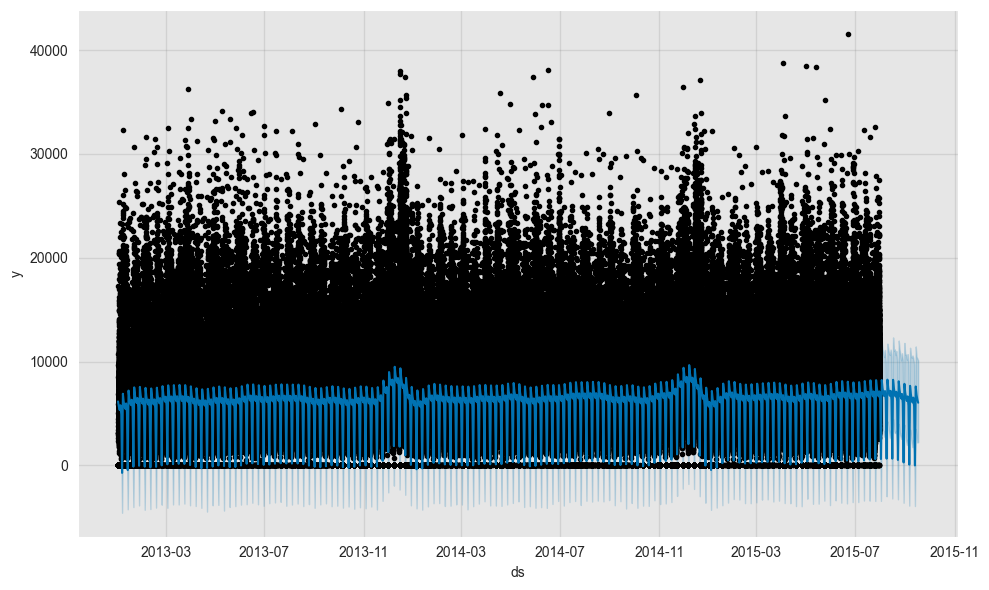

In [202]:
fig = m.plot(forecast_sales)

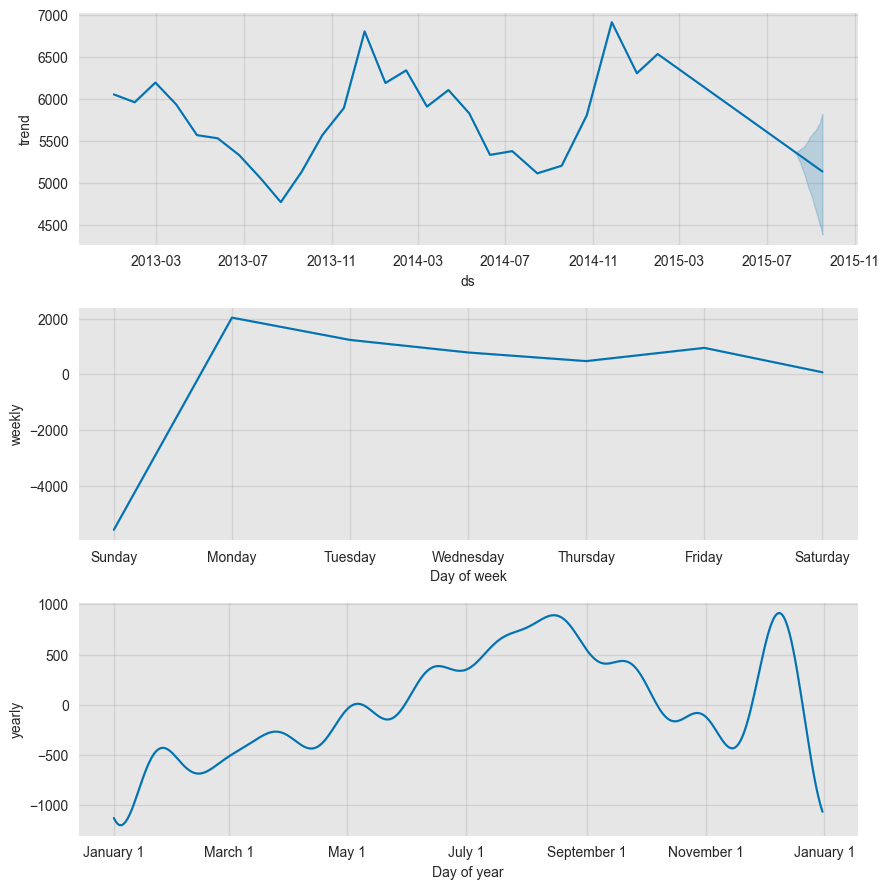

In [203]:
fig2 = m.plot_components(forecast_sales)

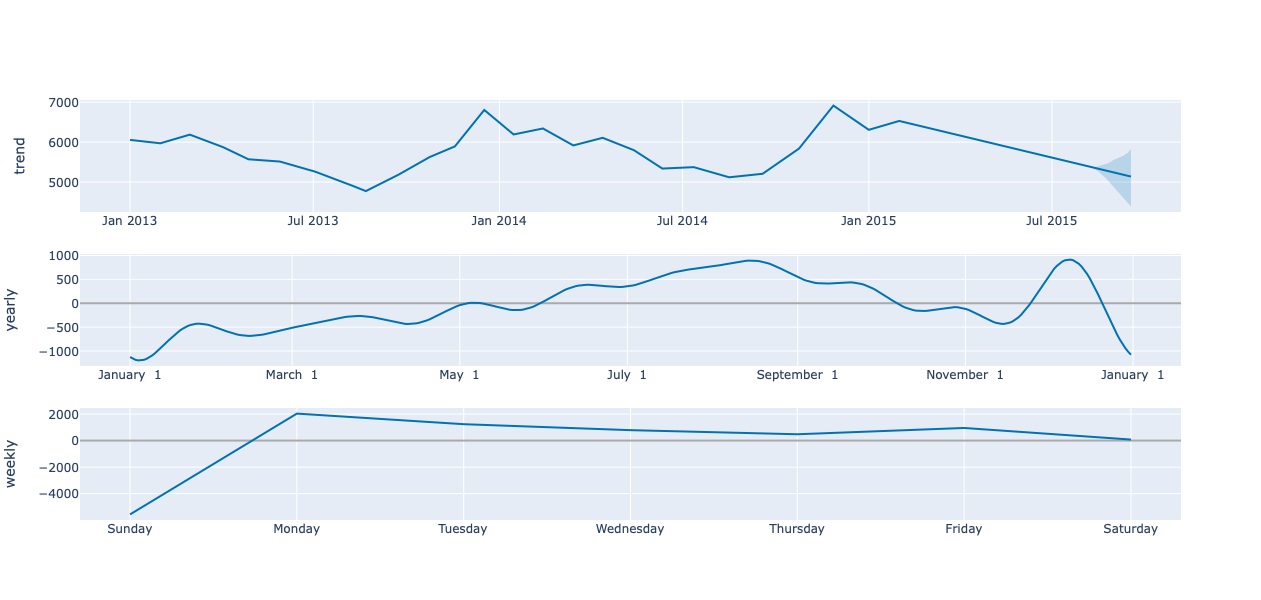

In [204]:
plot_components_plotly(m, forecast_sales)

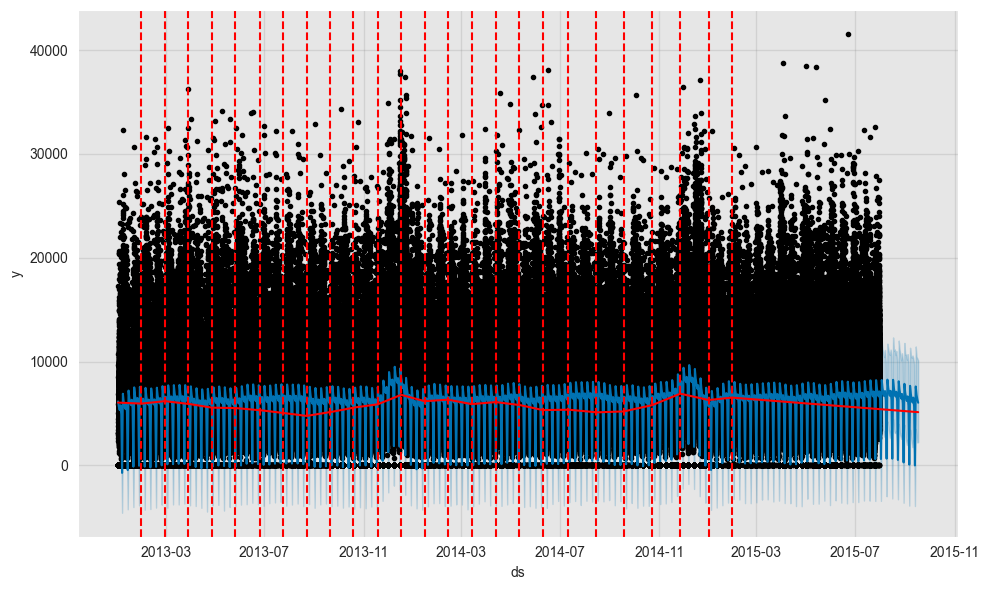

In [205]:
fig3 = m.plot(forecast_sales)
a = add_changepoints_to_plot(fig3.gca(), m, forecast_sales)

def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [789]:
#Define the evaluation function, you can pass in the loss function of the replacement model itself in the later model
#def rmspe(y,yhat):
    #return np.sqrt(np.mean((yhat/y-1)**2))

def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)


def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

inf

## Train Test Split

In [697]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   sales                      1017209 non-null  int64         
 3   customers                  1017209 non-null  int64         
 4   open                       1017209 non-null  int64         
 5   promo                      1017209 non-null  int64         
 6   schoolholiday              1017209 non-null  int64         
 7   competitiondistance        1017209 non-null  float64       
 8   competitionopensincemonth  1017209 non-null  float64       
 9   competitionopensinceyear   1017209 non-null  float64       
 10  promo2                     1017209 non-null  int64         
 11  promo2sinceweek            1017209 no

In [698]:
df_yx=df_ts.copy()

In [722]:
feature=df_yx.drop(["sales","salepercustomer","open","schoolholiday","timestamp"], axis=1)

In [723]:
target= df_yx.sales

In [724]:
target.value_counts()

0        172871
5674        215
5558        197
5483        196
6049        195
          ...  
17847         1
24317         1
25114         1
19154         1
21958         1
Name: sales, Length: 21734, dtype: int64

In [756]:
target

0           5263
1           6064
2           8314
3          13995
4           4822
           ...  
1017204        0
1017205        0
1017206        0
1017207        0
1017208        0
Name: sales, Length: 1017209, dtype: int64

In [725]:
#feature, target = self._validate_data(X, y, multi_output=True,
                                     accept_sparse="csc", dtype=DTYPE)

IndentationError: unexpected indent (<ipython-input-725-acae34f6f81b>, line 2)

In [726]:
df_yx.shape

(1017209, 23)

In [727]:
df.shape

(1017209, 28)

In [833]:
X_train,X_test, y_train, y_test= model_selection.train_test_split(feature,target, test_size=0.2, random_state=70)

In [834]:
y_test.shape

(203442,)

In [835]:
y_train.shape

(813767,)

In [836]:
X_test.shape

(203442, 18)

In [849]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203442 entries, 298719 to 292555
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   store                      203442 non-null  int64  
 1   dayofweek                  203442 non-null  int64  
 2   customers                  203442 non-null  int64  
 3   promo                      203442 non-null  int64  
 4   competitiondistance        203442 non-null  float64
 5   competitionopensincemonth  203442 non-null  float64
 6   competitionopensinceyear   203442 non-null  float64
 7   promo2                     203442 non-null  int64  
 8   promo2sinceweek            203442 non-null  float64
 9   promo2sinceyear            203442 non-null  float64
 10  year                       203442 non-null  int64  
 11  month                      203442 non-null  int64  
 12  day                        203442 non-null  int64  
 13  dayofyear               

In [837]:
X_train.shape

(813767, 18)

In [838]:
#X_train= np.asarray(X_train)

In [731]:
X_train.isnull().sum()

AttributeError: 'numpy.ndarray' object has no attribute 'isnull'

In [714]:
#y_train= np.asarray(y_train)

In [839]:
rfr= RandomForestRegressor(n_estimators=100,
                          criterion="mse",
                          max_depth=5,
                          min_samples_split=2,
                          min_samples_leaf=1,
                          min_weight_fraction_leaf=0.0,
                          max_features="auto",
                          max_leaf_nodes=None,
                          min_impurity_decrease=0.0,
                          min_impurity_split=None,
                          bootstrap=True,
                          oob_score=False,
                          random_state=70,
                
                          )

In [840]:
model_rfr= rfr.fit(X_train,y_train)

In [841]:
model_rfr

RandomForestRegressor(max_depth=5, random_state=70)

In [842]:
y_hat_rfr=model_rfr.predict(X_test)

In [843]:
df_y_hat_rfr= pd.DataFrame(y_hat_rfr)

In [844]:
df_y_hat_rfr.describe()

0
count  203442.000000
mean     5776.387740
std      3586.044398
min         0.000662
25%      4211.549063
50%      5705.908855
75%      7598.781459
max     19760.695139

In [845]:
rmse(y_hat_rfr,y_test)

0.4471060715890214

## xgboost

In [863]:
params= {"objective": "reg:linear",
         "booster": "gbtree",
         "eta": 0.03,
         "max_depth": 10,
         "subsample": 0.9,
         "colsample_bytree": 0.7,
         
         "seed": 10}

num_boost_round= 5000
watchlist=[(dtrain, "train"),(dtest, "test")]

In [864]:
dtrain= xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test,y_test)

In [865]:
model_xgb= xgb.train(params,dtrain,num_boost_round,feval=rmspe_xg,evals=watchlist, early_stopping_rounds=100)

[15:57:49] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:6779.98389	train-rmspe:nan	test-rmse:6783.23730	test-rmspe:nan
[1]	train-rmse:6581.74512	train-rmspe:nan	test-rmse:6585.05518	test-rmspe:nan
[2]	train-rmse:6389.60645	train-rmspe:nan	test-rmse:6393.09522	test-rmspe:nan
[3]	train-rmse:6204.20312	train-rmspe:nan	test-rmse:6207.61670	test-rmspe:nan
[4]	train-rmse:6023.63330	train-rmspe:nan	test-rmse:6027.11523	test-rmspe:nan
[5]	train-rmse:5880.79785	train-rmspe:nan	test-rmse:5884.50830	test-rmspe:nan
[6]	train-rmse:5709.31885	train-rmspe:nan	test-rmse:5713.16357	test-rmspe:nan
[7]	train-rmse:5562.46436	train-rmspe:nan	test-rmse:5566.40478	test-rmspe:nan
[8]	train-rmse:5402.08057	train-rmspe:nan	test-rmse:5406.12305	test-rmspe:nan
[9]	train-rmse:5246.80176	train-rmspe:nan	test-rmse:5250.96338	test-rmspe:nan
[10]	train-rmse:5095.06006	train-rmspe:nan	test-rmse:5099.26367	test-rm

In [857]:
y_hat_xgb = model_xgb.predict(xgb.DMatrix(X_test))

In [858]:
y_hat_xgb

array([  133.6346  , 10023.151   ,  4030.3074  , ...,  3923.8936  ,
        5879.551   ,   -36.417957], dtype=float32)

In [805]:
df_y_hat_xgb= pd.DataFrame(y_hat_xgb)

In [852]:
df_y_hat_xgb.describe()

0
count  203442.000000
mean     5780.396484
std      3797.724365
min      -489.670013
25%      3814.348938
50%      5784.407471
75%      7847.760376
max     35624.605469

In [859]:
rmspe_xg(y_hat_xgb,y_test)

AttributeError: 'Series' object has no attribute 'get_label'

In [869]:
error= rmspe(np.expm1(y_hat_xgb), np.expm1(y_test))
print("RMSPE: {:.4f}".format(error))

RMSPE: 1.0000


In [867]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

In [868]:
def rmspe_xgb(yhat, y):
    
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [870]:
rmspe_xgb(y_hat_xgb,y_test)

AttributeError: 'Series' object has no attribute 'get_label'